In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Loading and Cleaning the Data

In [97]:
df = pd.read_csv('/content/data_new.csv')
data_df = df.reset_index()
total_data = len(data_df)
data_df.info()
data_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48784 entries, 0 to 48783
Columns: 161 entries, index to gagne_sum_t
dtypes: float64(22), int64(138), object(1)
memory usage: 59.9+ MB


,index,risk_score_t,program_enrolled_t,cost_t,cost_avoidable_t,bps_mean_t,ghba1c_mean_t,hct_mean_t,cre_mean_t,ldl_mean_t,...,trig_min-high_tm1,trig_min-normal_tm1,trig_mean-low_tm1,trig_mean-high_tm1,trig_mean-normal_tm1,trig_max-low_tm1,trig_max-high_tm1,trig_max-normal_tm1,gagne_sum_tm1,gagne_sum_t
0,0,1.987430,0,1200.0,0.0,NaN,5.4,NaN,1.110000,194.0,...,0,0,0,0,0,0,0,0,0,0
1,1,7.677934,0,2600.0,0.0,119.0,5.5,40.4,0.860000,93.0,...,0,1,0,0,1,0,0,1,4,3
2,2,0.407678,0,500.0,0.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,3,0.798369,0,1300.0,0.0,117.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,4,17.513165,0,1100.0,0.0,116.0,NaN,34.1,1.303333,53.0,...,0,0,0,0,0,0,0,0,1,1


In [98]:
# Cleaning demographic variables
def gender_cleaning(obs):
  if obs == 1:
    return "Female"
  elif obs == 0:
    return "Male"

def race_cleaning(obs):
  if obs == "black":
    return 0
  elif obs == "white":
    return 1

age_data = data_df[['dem_age_band_18-24_tm1','dem_age_band_25-34_tm1','dem_age_band_35-44_tm1','dem_age_band_45-54_tm1','dem_age_band_55-64_tm1','dem_age_band_65-74_tm1','dem_age_band_75+_tm1']]
age_counts = age_data.sum()
melted_age = pd.melt(age_data)
melted_age = melted_age[melted_age['value'] == 1]
# Applying cleaning functions
data_df['dem_gender'] = data_df['dem_female'].apply(lambda x: gender_cleaning(x))
data_df['dem_white'] = data_df['race'].apply(lambda x: race_cleaning(x))

In [99]:
# DEMOGRAPHIC DATA
def print_plots():
  # Gender chart
  sns.countplot(x='dem_gender', data=data_df, palette='Paired')
  plt.title("Count by Gender")
  plt.xlabel("Gender")
  plt.ylabel("Count")
  plt.show()

  gender_count = pd.crosstab(index = data_df['dem_gender'], columns = 'Count')
  gender_count.columns = ['Count']
  gender_count['Percentage'] = gender_count.sum(axis=1)
  gender_count['Percentage'] = gender_count['Percentage'].div(total_data) * 100
  display(gender_count)

  # Race chart
  sns.countplot(x='race', data=data_df, palette='Set2')
  plt.title("Count by Race")
  plt.xlabel("Race")
  plt.ylabel("Count")
  plt.show()

  race_count = pd.crosstab(index = data_df['race'], columns = 'Count')
  race_count.columns = ['Count']
  race_count['Percentage'] = race_count.sum(axis=1)
  race_count['Percentage'] = race_count['Percentage'].div(total_data) * 100
  display(race_count)

  # Age band chart
  plt.figure(figsize=(15, 6))
  sns.barplot(x=age_counts.index, y=age_counts.values)
  plt.xticks(range(len(age_counts)), [label.split('_')[3] for label in age_counts.index])
  plt.title('Counts for Each Age Band')
  plt.xlabel('Age Band')
  plt.ylabel('Count')
  plt.show()

  age_count = pd.crosstab(index=melted_age['variable'], columns=melted_age['value'])
  age_count.index = ['18-24', '25-34', '35-44', '45-54', '55-64','65-74','75+']
  age_count.columns = ['Count']
  age_count['Percentage'] = age_count.sum(axis=1)
  total_age = age_counts.sum()
  age_count['Percentage'] = age_count['Percentage'].div(total_age) * 100
  display(age_count)


In [100]:
# DIVIDING FEATURE BY TYPE

def get_comorbidity_feats(df):
    comorbidity_feats = []
    suffix_elixhauser = '_elixhauser_tm1'
    suffix_romano = '_romano_tm1'

    for column in df.columns:
        if suffix_elixhauser == column[-len(suffix_elixhauser):]:
            comorbidity_feats.append(column)
        elif suffix_romano == column[-len(suffix_romano):]:
            comorbidity_feats.append(column)
        else:
            continue
    return comorbidity_feats

def get_lab_feats(df):

    lab_feats = []
    suffix_labs_counts = '_tests_tm1'
    suffix_labs_low = '-low_tm1'
    suffix_labs_high = '-high_tm1'
    suffix_labs_normal = '-normal_tm1'
    for col in df.columns:
        if suffix_labs_counts == col[-len(suffix_labs_counts):]:
            lab_feats.append(col)
        elif suffix_labs_low == col[-len(suffix_labs_low):]:
            lab_feats.append(col)
        elif suffix_labs_high == col[-len(suffix_labs_high):]:
            lab_feats.append(col)
        elif suffix_labs_normal == col[-len(suffix_labs_normal):]:
            lab_feats.append(col)
        else:
            continue
    return lab_feats

def get_med_feats(df):

    med_feats = []
    prefix = 'lasix_'
    for col in df.columns:
        if prefix == col[:len(prefix)]:
            med_feats.append(col)
    return med_feats

def get_cont_feats(df):

    test_feats = []
    suffix = 'tests_tm1'
    suffix2 = "mean_t"
    for col in df.columns:
        if suffix == col[-len(suffix):]:
            test_feats.append(col)
        elif suffix2 == col[-len(suffix2):]:
            test_feats.append(col)
    return test_feats

In [101]:
from scipy.stats import percentileofscore

def create_table(df, race, total_n):
    df = df.copy()
    table_list = []

    n = len(df) * 1.0
    table_list.append(('n (patient-years)', '{:,}'.format(n)))

    # Demographics

    table_list.append(('Demographics', '---'))
    table_list.append(('Female', '{:.2f}'.format(df['dem_female'].sum() / n)))
    table_list.append(('Age 18-24','{:.2f}'.format(df['dem_age_band_18-24_tm1'].sum() / n)))
    table_list.append(('Age 25-34', '{:.2f}'.format(df['dem_age_band_25-34_tm1'].sum() / n)))
    table_list.append(('Age 35-44', '{:.2f}'.format(df['dem_age_band_35-44_tm1'].sum() / n)))
    table_list.append(('Age 45-54', '{:.2f}'.format(df['dem_age_band_45-54_tm1'].sum() / n)))
    table_list.append(('Age 55-64', '{:.2f}'.format(df['dem_age_band_55-64_tm1'].sum() / n)))
    table_list.append(('Age 65-74', '{:.2f}'.format(df['dem_age_band_65-74_tm1'].sum() / n)))
    table_list.append(('Age 75+', '{:.2f}'.format(df['dem_age_band_75+_tm1'].sum() / n)))

    # Care management program

    table_list.append(('Care management program', '---'))
    df['risk_score_t_percentile'] = df['risk_score_t'].apply(lambda x: percentileofscore(df['risk_score_t'], x))
    table_list.append(('Algorithm score (mean percentile)', '{:.0f}'.format(df['risk_score_t_percentile'].mean())))

    # Care utilization

    table_list.append(('Care utilization', '---'))
    table_list.append(('Actual cost (mean)', '${:,.0f}'.format(df['cost_t'].mean())))

    # Mean biomarker values

    table_list.append(('Mean biomarkers', '---'))
    table_list.append(('HbA1c', '{:.1f}'.format(df['ghba1c_mean_t'].mean())))
    table_list.append(('Systolic BP', '{:.1f}'.format(df['bps_mean_t'].mean())))
    table_list.append(('Creatinine', '{:.1f}'.format(df['cre_mean_t'].mean())))
    table_list.append(('Hematocrit', '{:.1f}'.format(df['hct_mean_t'].mean())))
    table_list.append(('LDL', '{:.1f}'.format(df['ldl_mean_t'].mean())))

    # Active chronic illnesses (comorbidities)

    table_list.append(('Active chronic illnesses (mean comorbidities)', '---'))
    table_list.append(('Total number of active illnesses', '{:.2f}'.format(df['gagne_sum_t'].mean())))
    table_list.append(('Hypertension',
        '{:.2f}'.format(df['hypertension_elixhauser_tm1'].mean())))
    table_list.append(('Diabetes, uncomplicated', '{:.2f}'.format(df['uncompdiabetes_elixhauser_tm1'].mean())))
    table_list.append(('Arrythmia',
        '{:.2f}'.format(df['arrhythmia_elixhauser_tm1'].mean())))
    table_list.append(('Hypothyroid', '{:.2f}'.format(df['hypothyroid_elixhauser_tm1'].mean())))
    table_list.append(('Obesity', '{:.2f}'.format(df['obesity_elixhauser_tm1'].mean())))
    table_list.append(('Pulmonary disease', '{:.2f}'.format(df['pulmonarydz_romano_tm1'].mean())))
    table_list.append(('Cancer', '{:.2f}'.format(df['tumor_romano_tm1'].mean())))
    table_list.append(('Depression', '{:.2f}'.format(df['depression_elixhauser_tm1'].mean())))
    table_list.append(('Anemia', '{:.2f}'.format(df['anemia_elixhauser_tm1'].mean())))
    table_list.append(('Arthritis', '{:.2f}'.format(df['arthritis_elixhauser_tm1'].mean())))
    table_list.append(('Renal failure', '{:.2f}'.format(df['renal_elixhauser_tm1'].mean())))
    table_list.append(('Electrolyte disorder', '{:.2f}'.format(df['electrolytes_elixhauser_tm1'].mean())))
    table_list.append(('Heart failure', '{:.2f}'.format(df['chf_romano_tm1'].mean())))
    table_list.append(('Psychosis', '{:.2f}'.format(df['psychosis_elixhauser_tm1'].mean())))
    table_list.append(('Valvular disease', '{:.2f}'.format(df['valvulardz_elixhauser_tm1'].mean())))
    table_list.append(('Stroke', '{:.2f}'.format(df['hemiplegia_romano_tm1'].mean())))
    table_list.append(('Peripheral vascular disease', '{:.2f}'.format(df['pvd_elixhauser_tm1'].mean())))
    table_list.append(('Diabetes, complicated', '{:.2f}'.format(df['compdiabetes_elixhauser_tm1'].mean())))
    table_list.append(('Heart attack', '{:.2f}'.format(df['myocardialinfarct_romano_tm1'].mean())))
    table_list.append(('Liver disease', '{:.2f}'.format(df['liver_elixhauser_tm1'].mean())))

    table1_df = pd.DataFrame(table_list, columns=['Descriptive stats', race])

    return table1_df

def build_table():

    total_n = total_data * 1.0

    # Split by white, Black patients
    white_df = data_df[data_df['race'] == 'white']
    black_df = data_df[data_df['race'] == 'black']

    white_table = create_table(white_df, 'White', total_n)
    black_table = create_table(black_df, 'Black', total_n)

    # Merge white table and Black table for final table
    table = white_table.merge(black_table)

    display(table)

In [102]:
build_table()

,Descriptive stats,White,Black
0,n (patient-years),"43,202.0","5,582.0"
1,Demographics,---,---
2,Female,0.63,0.66
3,Age 18-24,0.04,0.04
4,Age 25-34,0.11,0.11
5,Age 35-44,0.19,0.20
6,Age 45-54,0.24,0.25
7,Age 55-64,0.20,0.18
8,Age 65-74,0.14,0.14
9,Age 75+,0.07,0.07


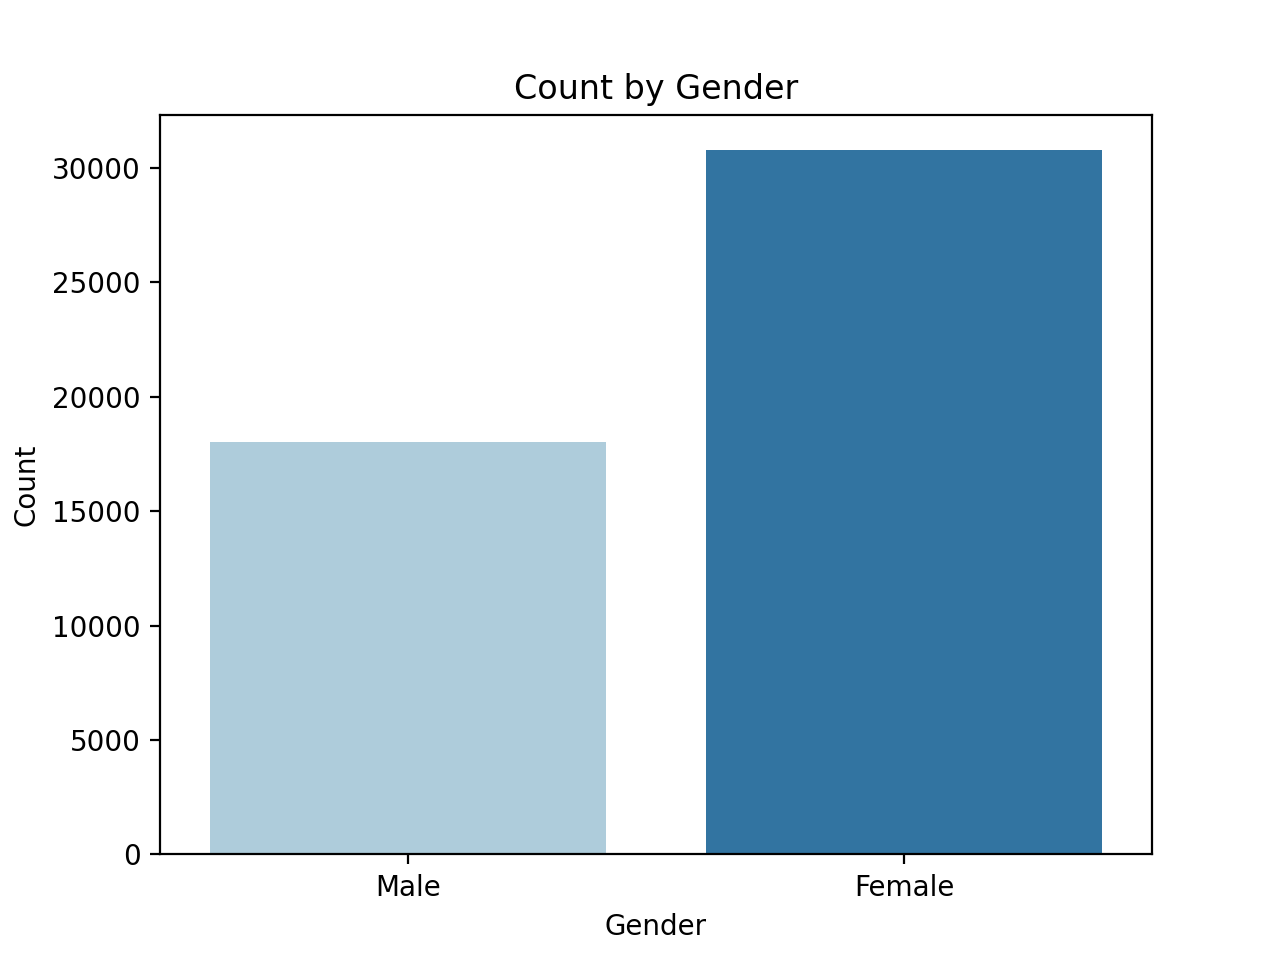

,Count,Percentage
dem_gender,,
Female,30763,63.05961
Male,18021,36.94039


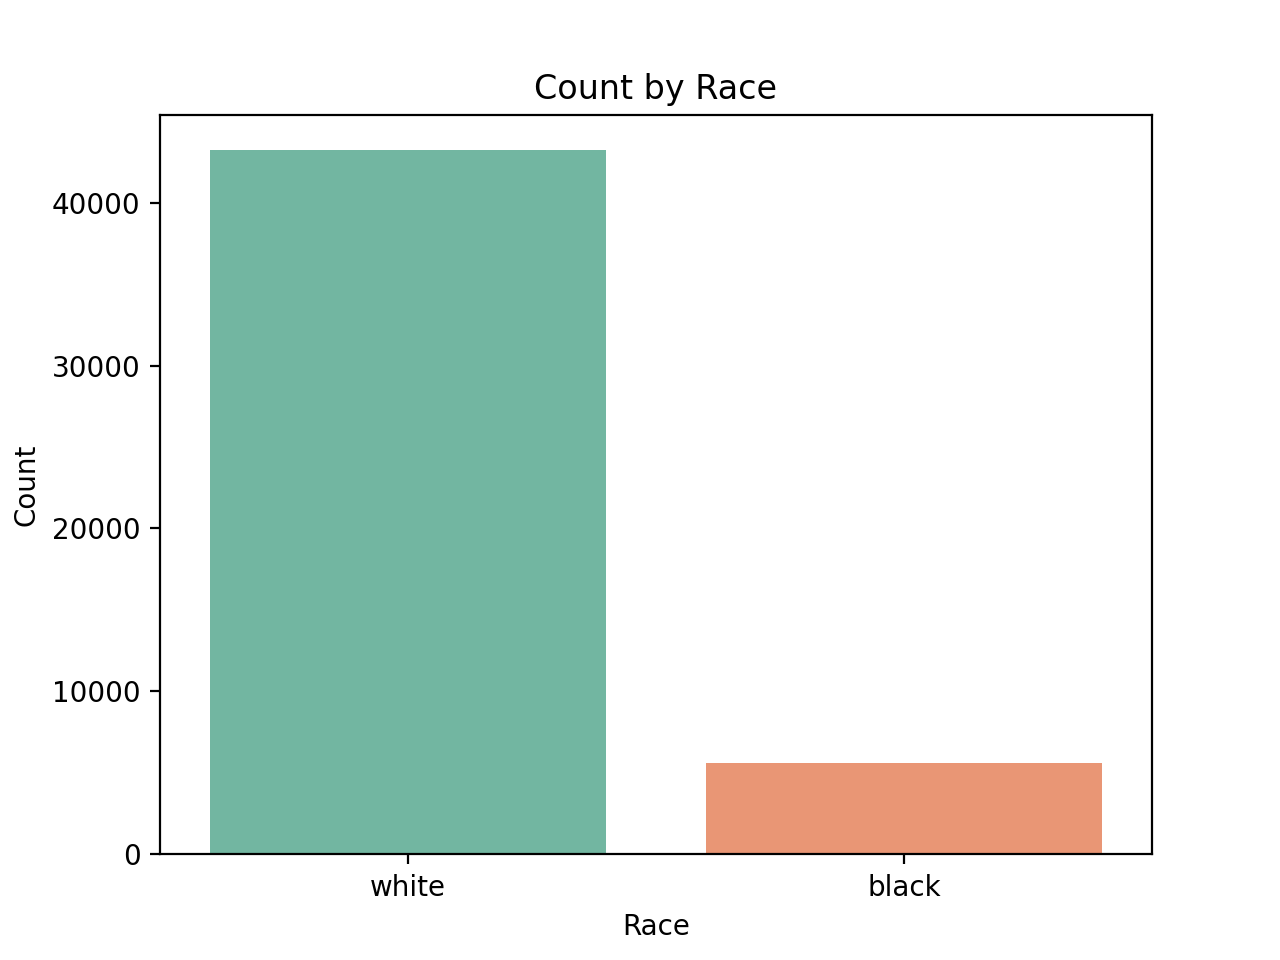

,Count,Percentage
race,,
black,5582,11.442276
white,43202,88.557724


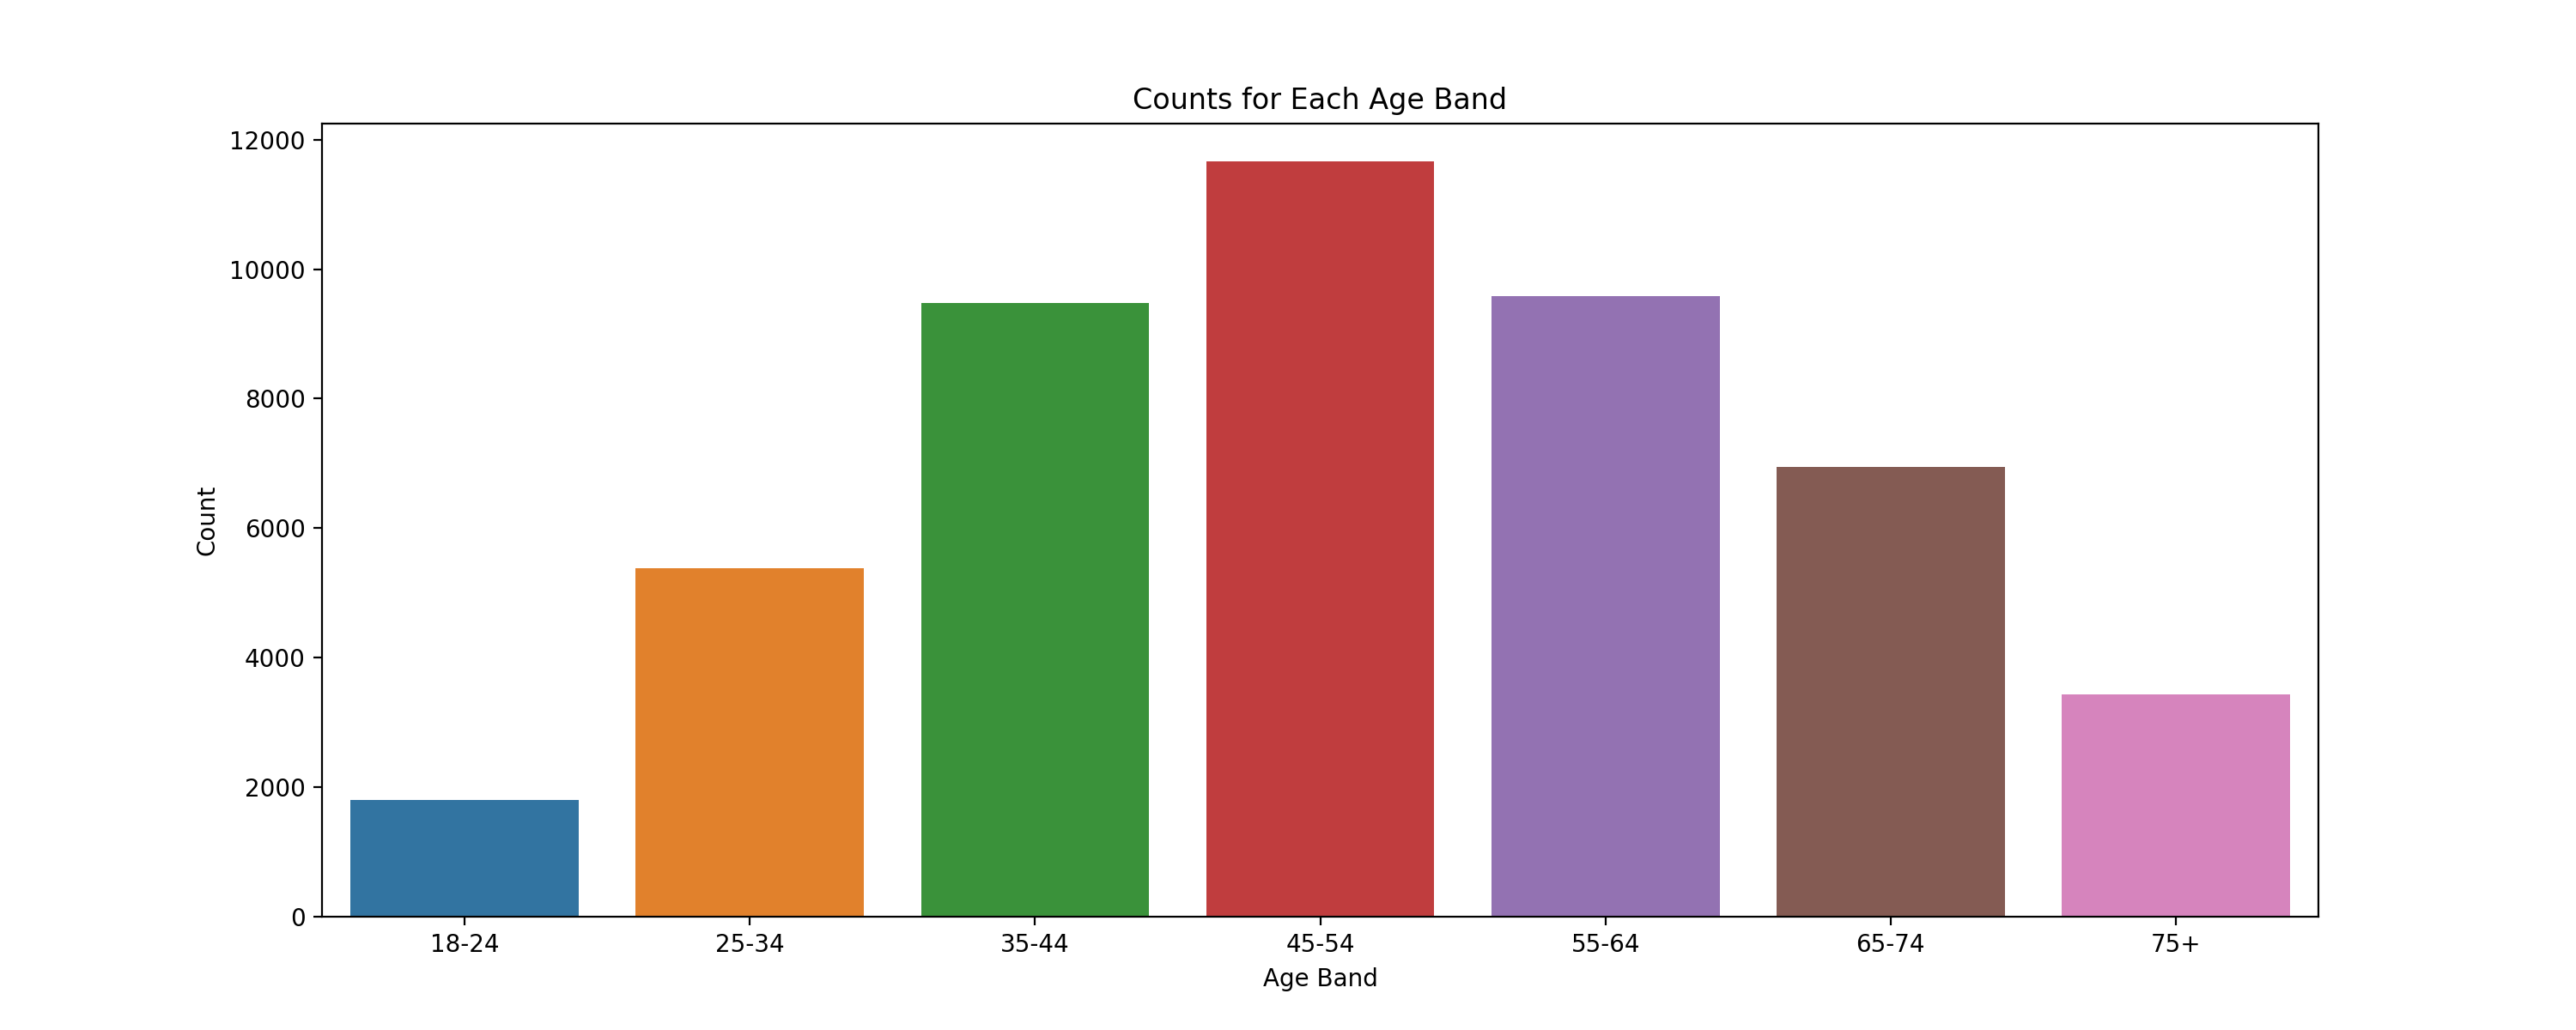

,Count,Percentage
18-24,1799,3.725872
25-34,5380,11.142407
35-44,9481,19.635904
45-54,11665,24.159142
55-64,9590,19.861652
65-74,6940,14.373291
75+,3429,7.101731


In [103]:
print_plots()

### Predictive Analytics

In [104]:
data = pd.read_csv("/content/data_new.csv")

In [105]:
# To find how much missing data is in each column:
# Count the missing values in each column
missing_values = data.isnull().sum()

# Sum the total number of missing values in the entire DataFrame
total_missing_values = missing_values.sum()

# Print the results
print("Number of missing values in each column:")
print(missing_values)
print("\nTotal number of missing values in the DataFrame:", total_missing_values)

Number of missing values in each column:
risk_score_t               0
program_enrolled_t         0
cost_t                     0
cost_avoidable_t           0
bps_mean_t             10668
                       ...  
trig_max-low_tm1           0
trig_max-high_tm1          0
trig_max-normal_tm1        0
gagne_sum_tm1              0
gagne_sum_t                0
Length: 160, dtype: int64

Total number of missing values in the DataFrame: 127857


In [106]:
percentile_55 = data["risk_score_t"].quantile(0.55)
percentile_97 = data["risk_score_t"].quantile(0.97)

In [107]:
data["Referral"] = np.select([data["risk_score_t"] > percentile_97, (data["risk_score_t"] > percentile_55) & (data["risk_score_t"] <= percentile_97), data["risk_score_t"] <= percentile_55],
    [2, 1, 0],
    default=0)

### Creating Clusters

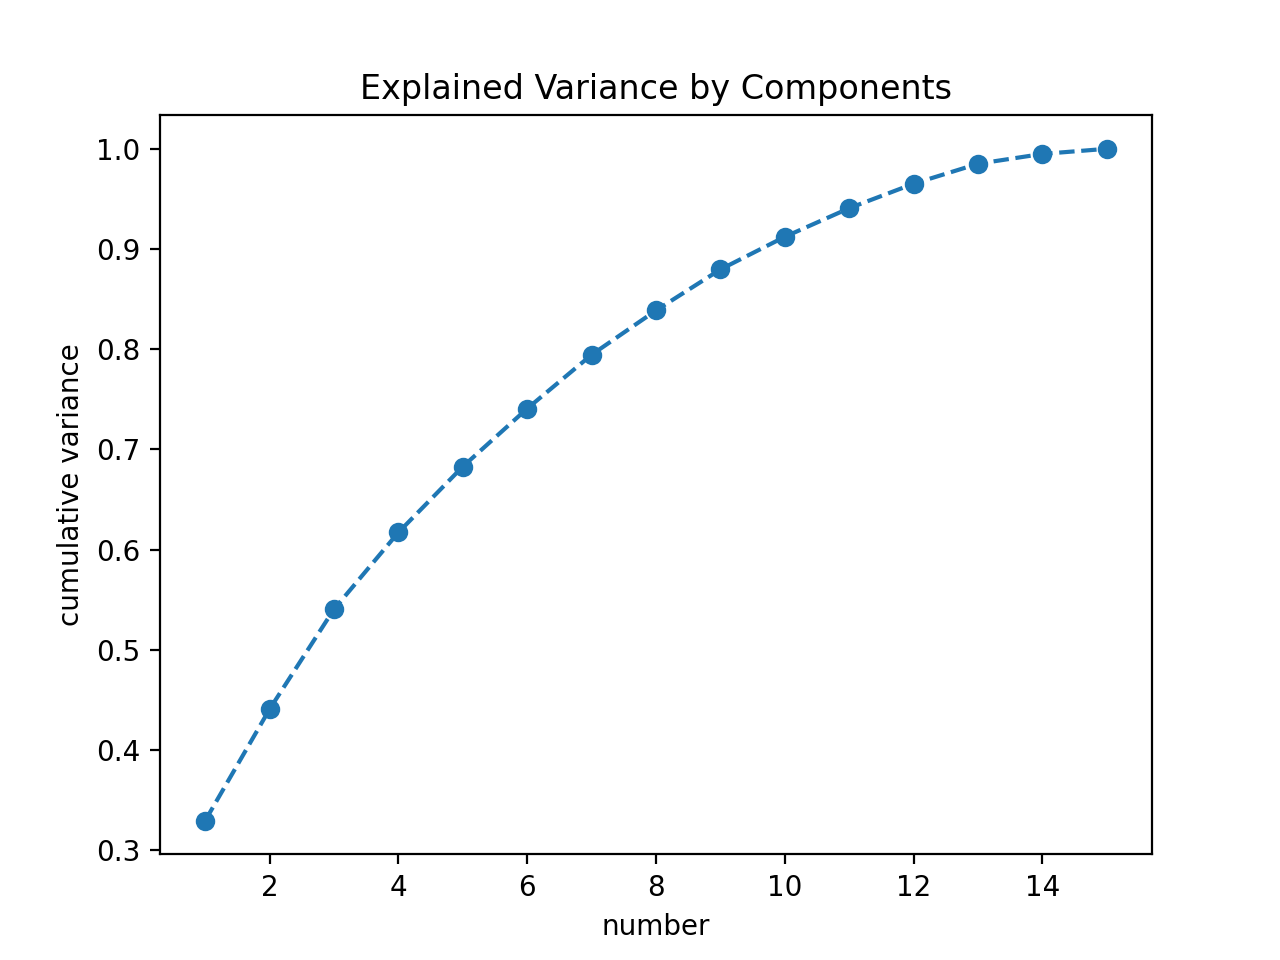

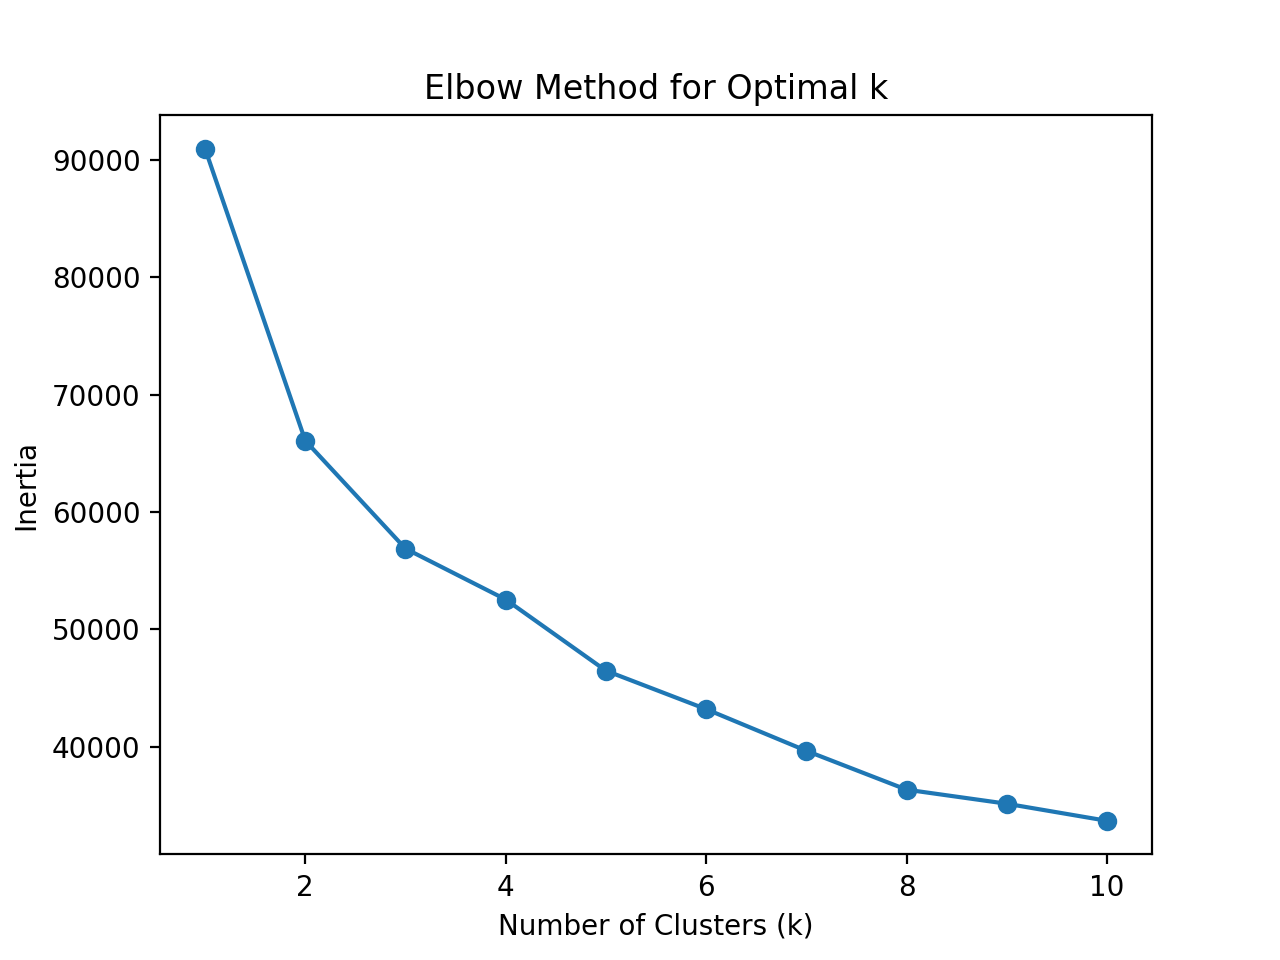

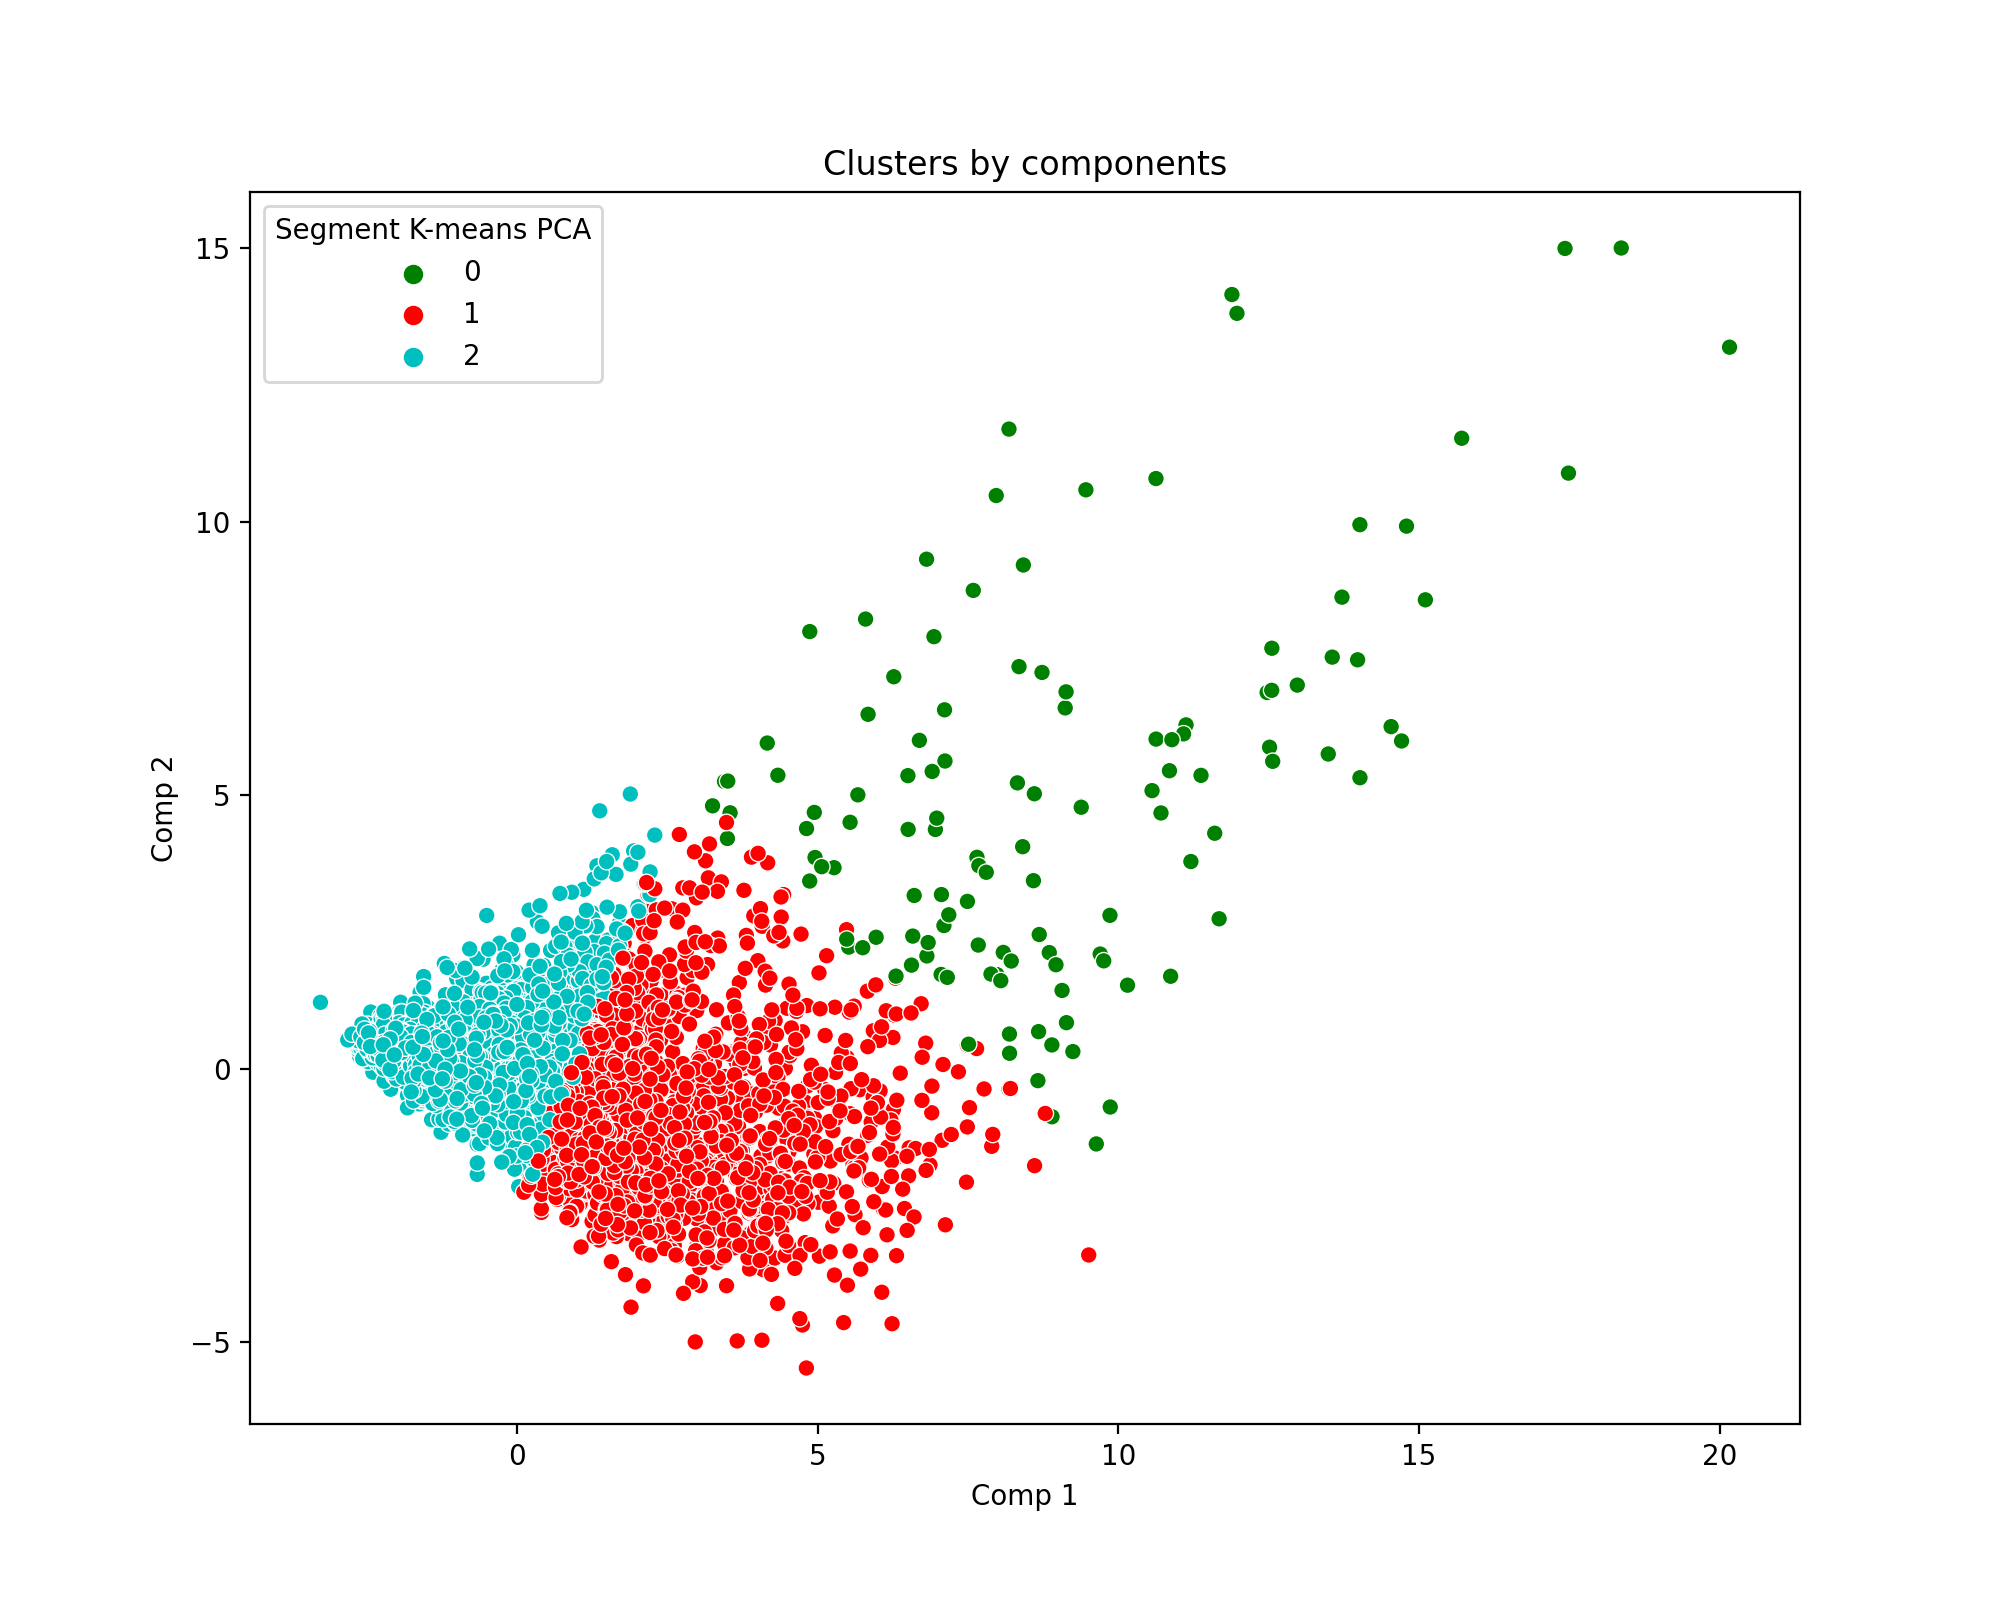

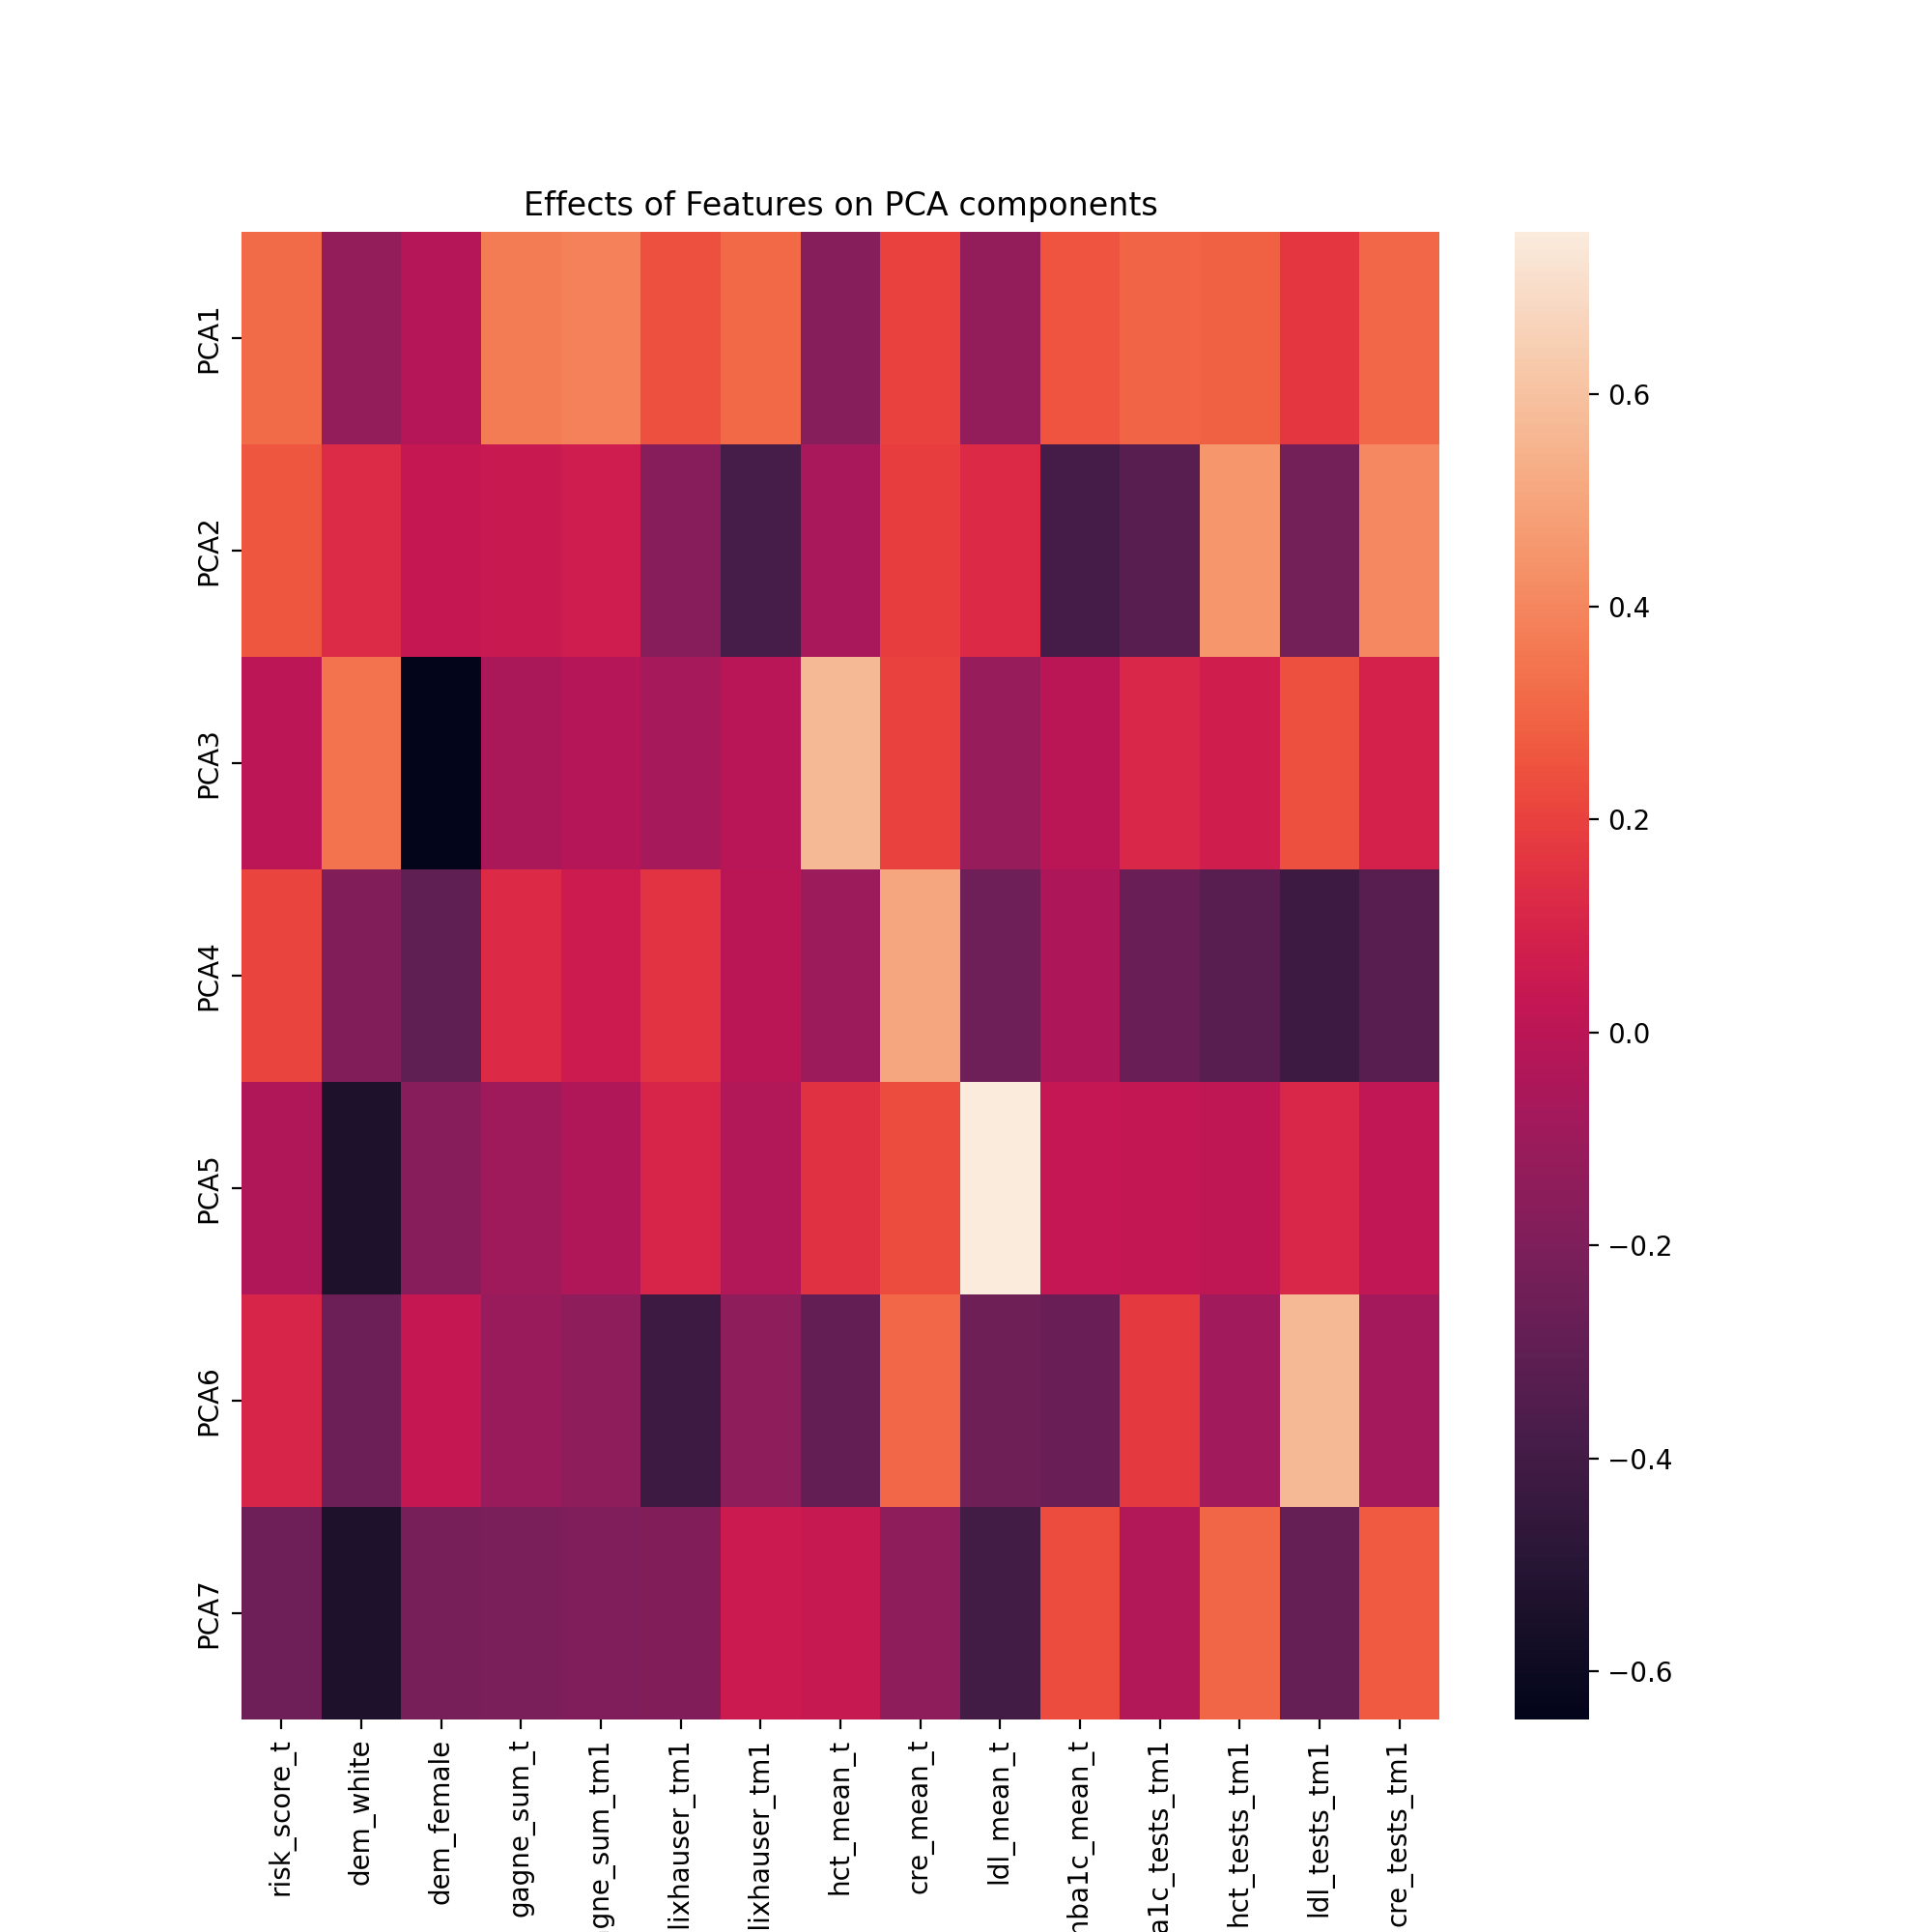

In [108]:
#https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# With demographics, some biomarkers, and no cost

selected_columns = ['risk_score_t', 'dem_white', 'dem_female', 'gagne_sum_t', 'gagne_sum_tm1','compdiabetes_elixhauser_tm1', 'uncompdiabetes_elixhauser_tm1','hct_mean_t', 'cre_mean_t', 'ldl_mean_t','ghba1c_mean_t', 'ghba1c_tests_tm1', 'hct_tests_tm1', 'ldl_tests_tm1', 'cre_tests_tm1']
copy_df = data_df.copy()
data_subset = copy_df[selected_columns].dropna()

# Standardize
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_subset)

# Fitting the data
pca = PCA()
pca.fit(scaled_data)

plt.plot(range(1,16), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Explained Variance by Components')
plt.xlabel('number')
plt.ylabel('cumulative variance')
plt.show()


pca=PCA(n_components = 7)
pca.fit(scaled_data)
scores_pca = pca.transform(scaled_data)

# Optimal number of clusters using the Elbow method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(scores_pca)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

# Based on the Elbow curve
optimal_k = 3

# # Apply kMeans clustering
kmeans_pca = KMeans(n_clusters=optimal_k, random_state=42, init = 'k-means++', n_init='auto')
kmeans_pca.fit(scores_pca)

df_pca = pd.concat([data_subset.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)
df_pca.columns.values[-7:] = ['Comp 1','Comp 2','Comp 3','Comp 4','Comp 5','Comp 6','Comp 7']
df_pca["Segment K-means PCA"] = kmeans_pca.labels_

x_axis = df_pca['Comp 1']
y_axis = df_pca['Comp 2']

plt.figure(figsize = (10,8))
sns.scatterplot(x = x_axis, y = y_axis, hue = df_pca["Segment K-means PCA"], palette = ['g','r','c'])
plt.title('Clusters by components')
plt.show()

# Represent the effect Features on PCA components
components=pd.DataFrame(pca.components_ ,index=['PCA1',"PCA2", "PCA3", "PCA4", "PCA5", "PCA6","PCA7"],columns=selected_columns)
plt.figure(figsize = (10,10))
sns.heatmap(components)
plt.title("Effects of Features on PCA components")
plt.show()

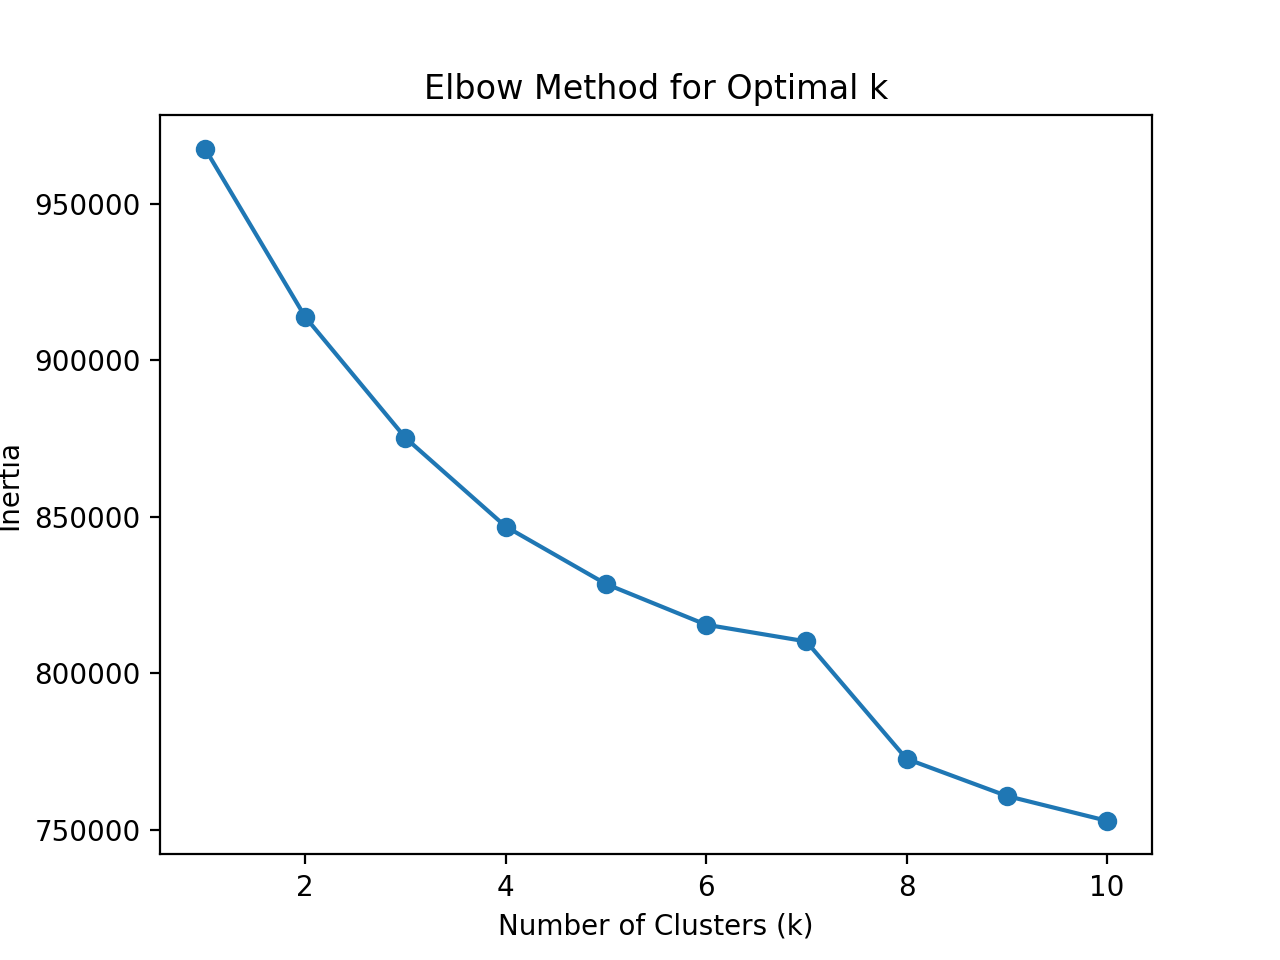

<ipython-input-109-8b4bcafdb7f2>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


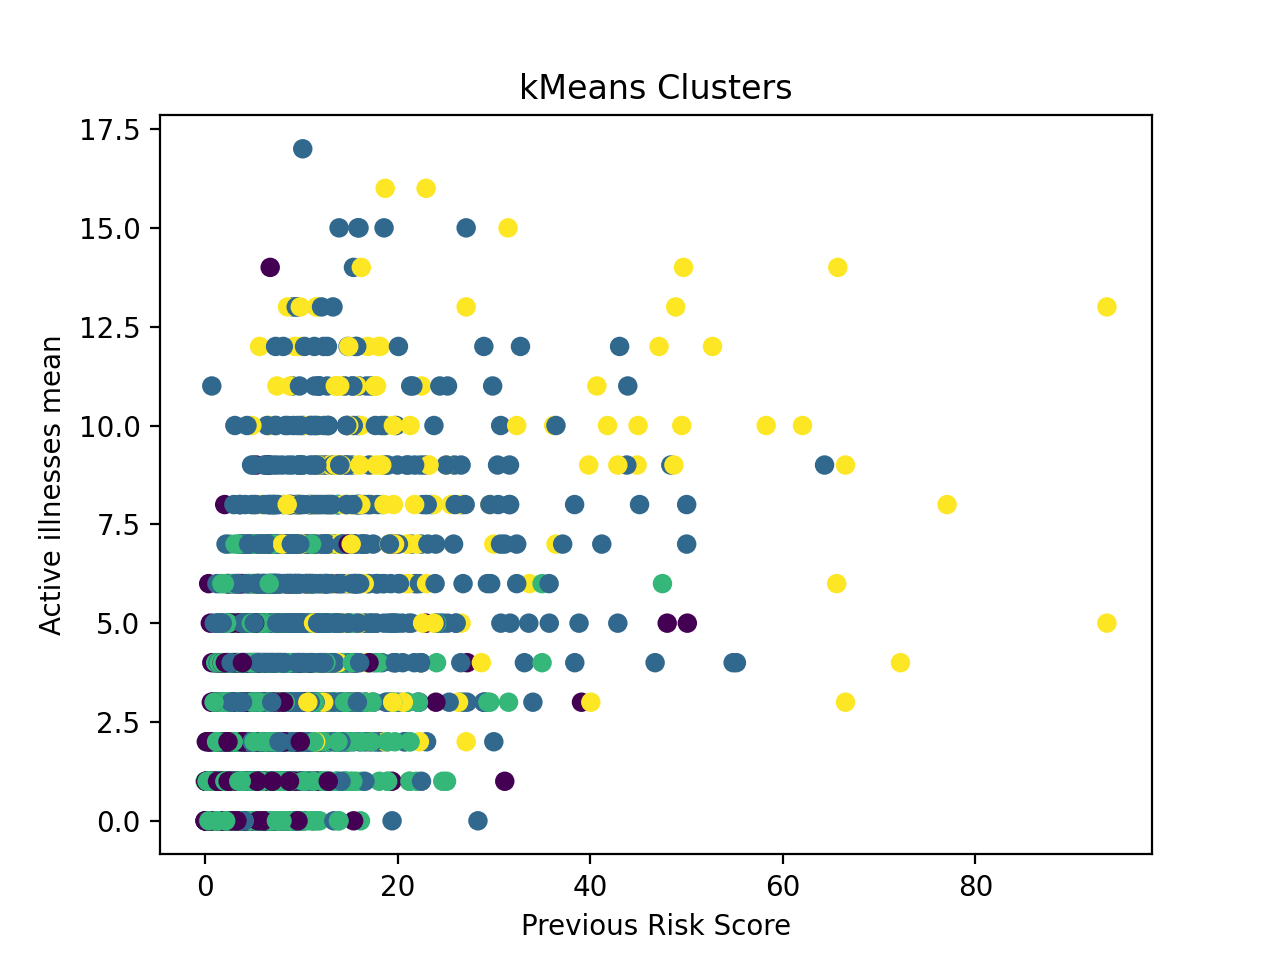

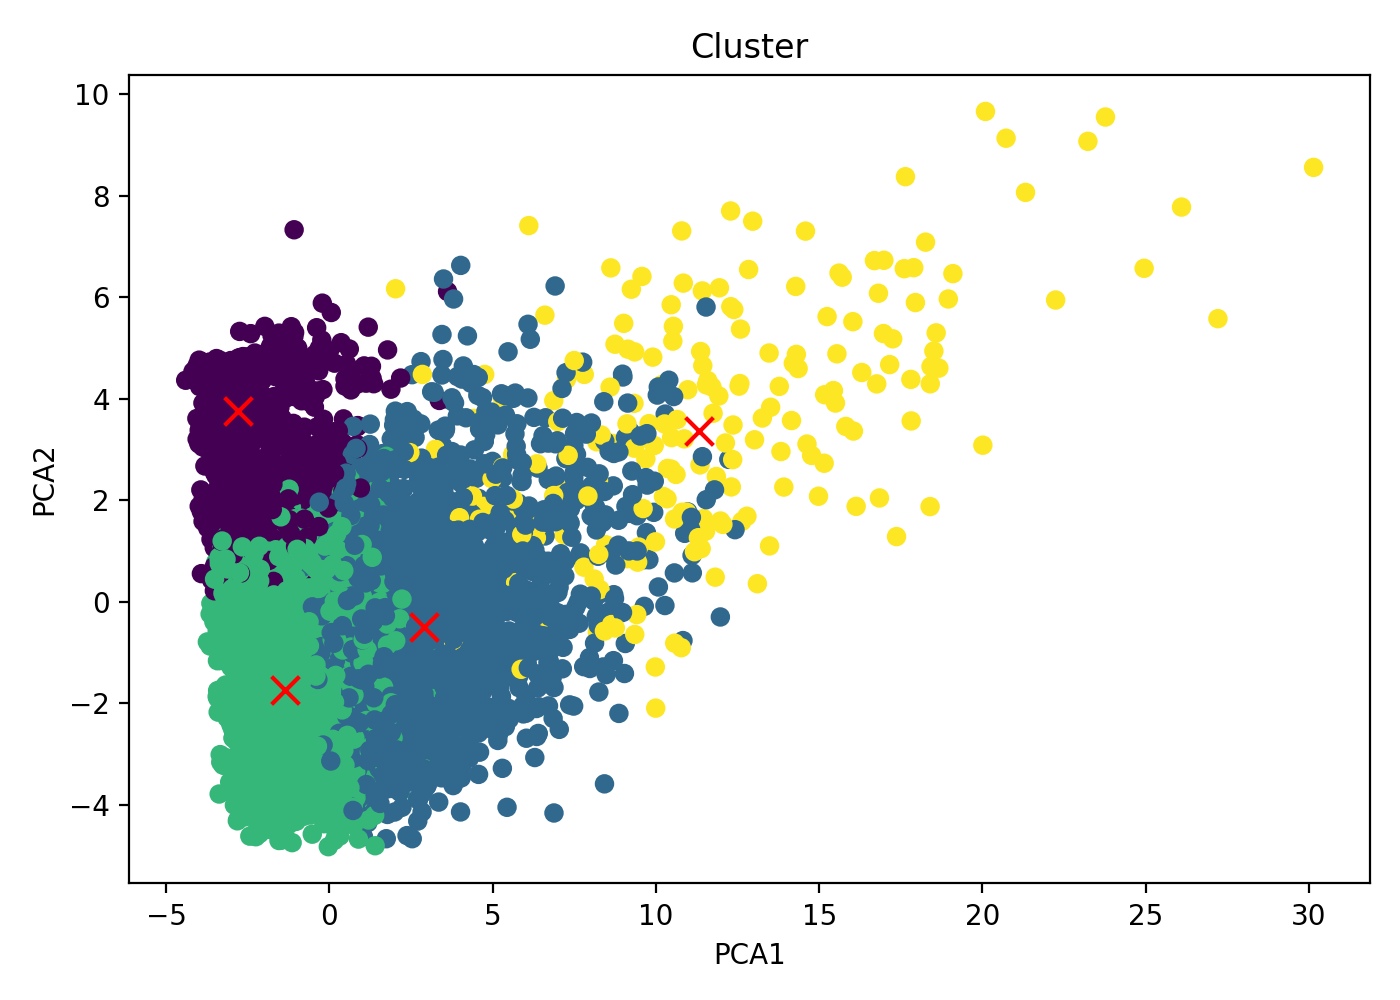

      risk_score_t  program_enrolled_t  bps_mean_t  ghba1c_mean_t  hct_mean_t  \
PCA1     -0.000507            0.190384    0.056125       0.056404    0.130599   
PCA2      0.002205            0.042186    0.023539      -0.013480   -0.001399   

      cre_mean_t  ldl_mean_t  dem_female  dem_age_band_18-24_tm1  \
PCA1   -0.089102    0.129791   -0.072731               -0.029259   
PCA2   -0.058677    0.052087   -0.005782                0.015701   

      dem_age_band_25-34_tm1  ...  trig_mean-low_tm1  trig_mean-high_tm1  \
PCA1               -0.016918  ...           0.025733            0.004074   
PCA2                0.014712  ...          -0.224320           -0.035581   

      trig_mean-normal_tm1  trig_max-low_tm1  trig_max-high_tm1  \
PCA1              0.069664          0.014991           0.002904   
PCA2             -0.040556         -0.217271          -0.032935   

      trig_max-normal_tm1  gagne_sum_tm1  gagne_sum_t  dem_white   cluster  
PCA1             0.078288       0.009408   

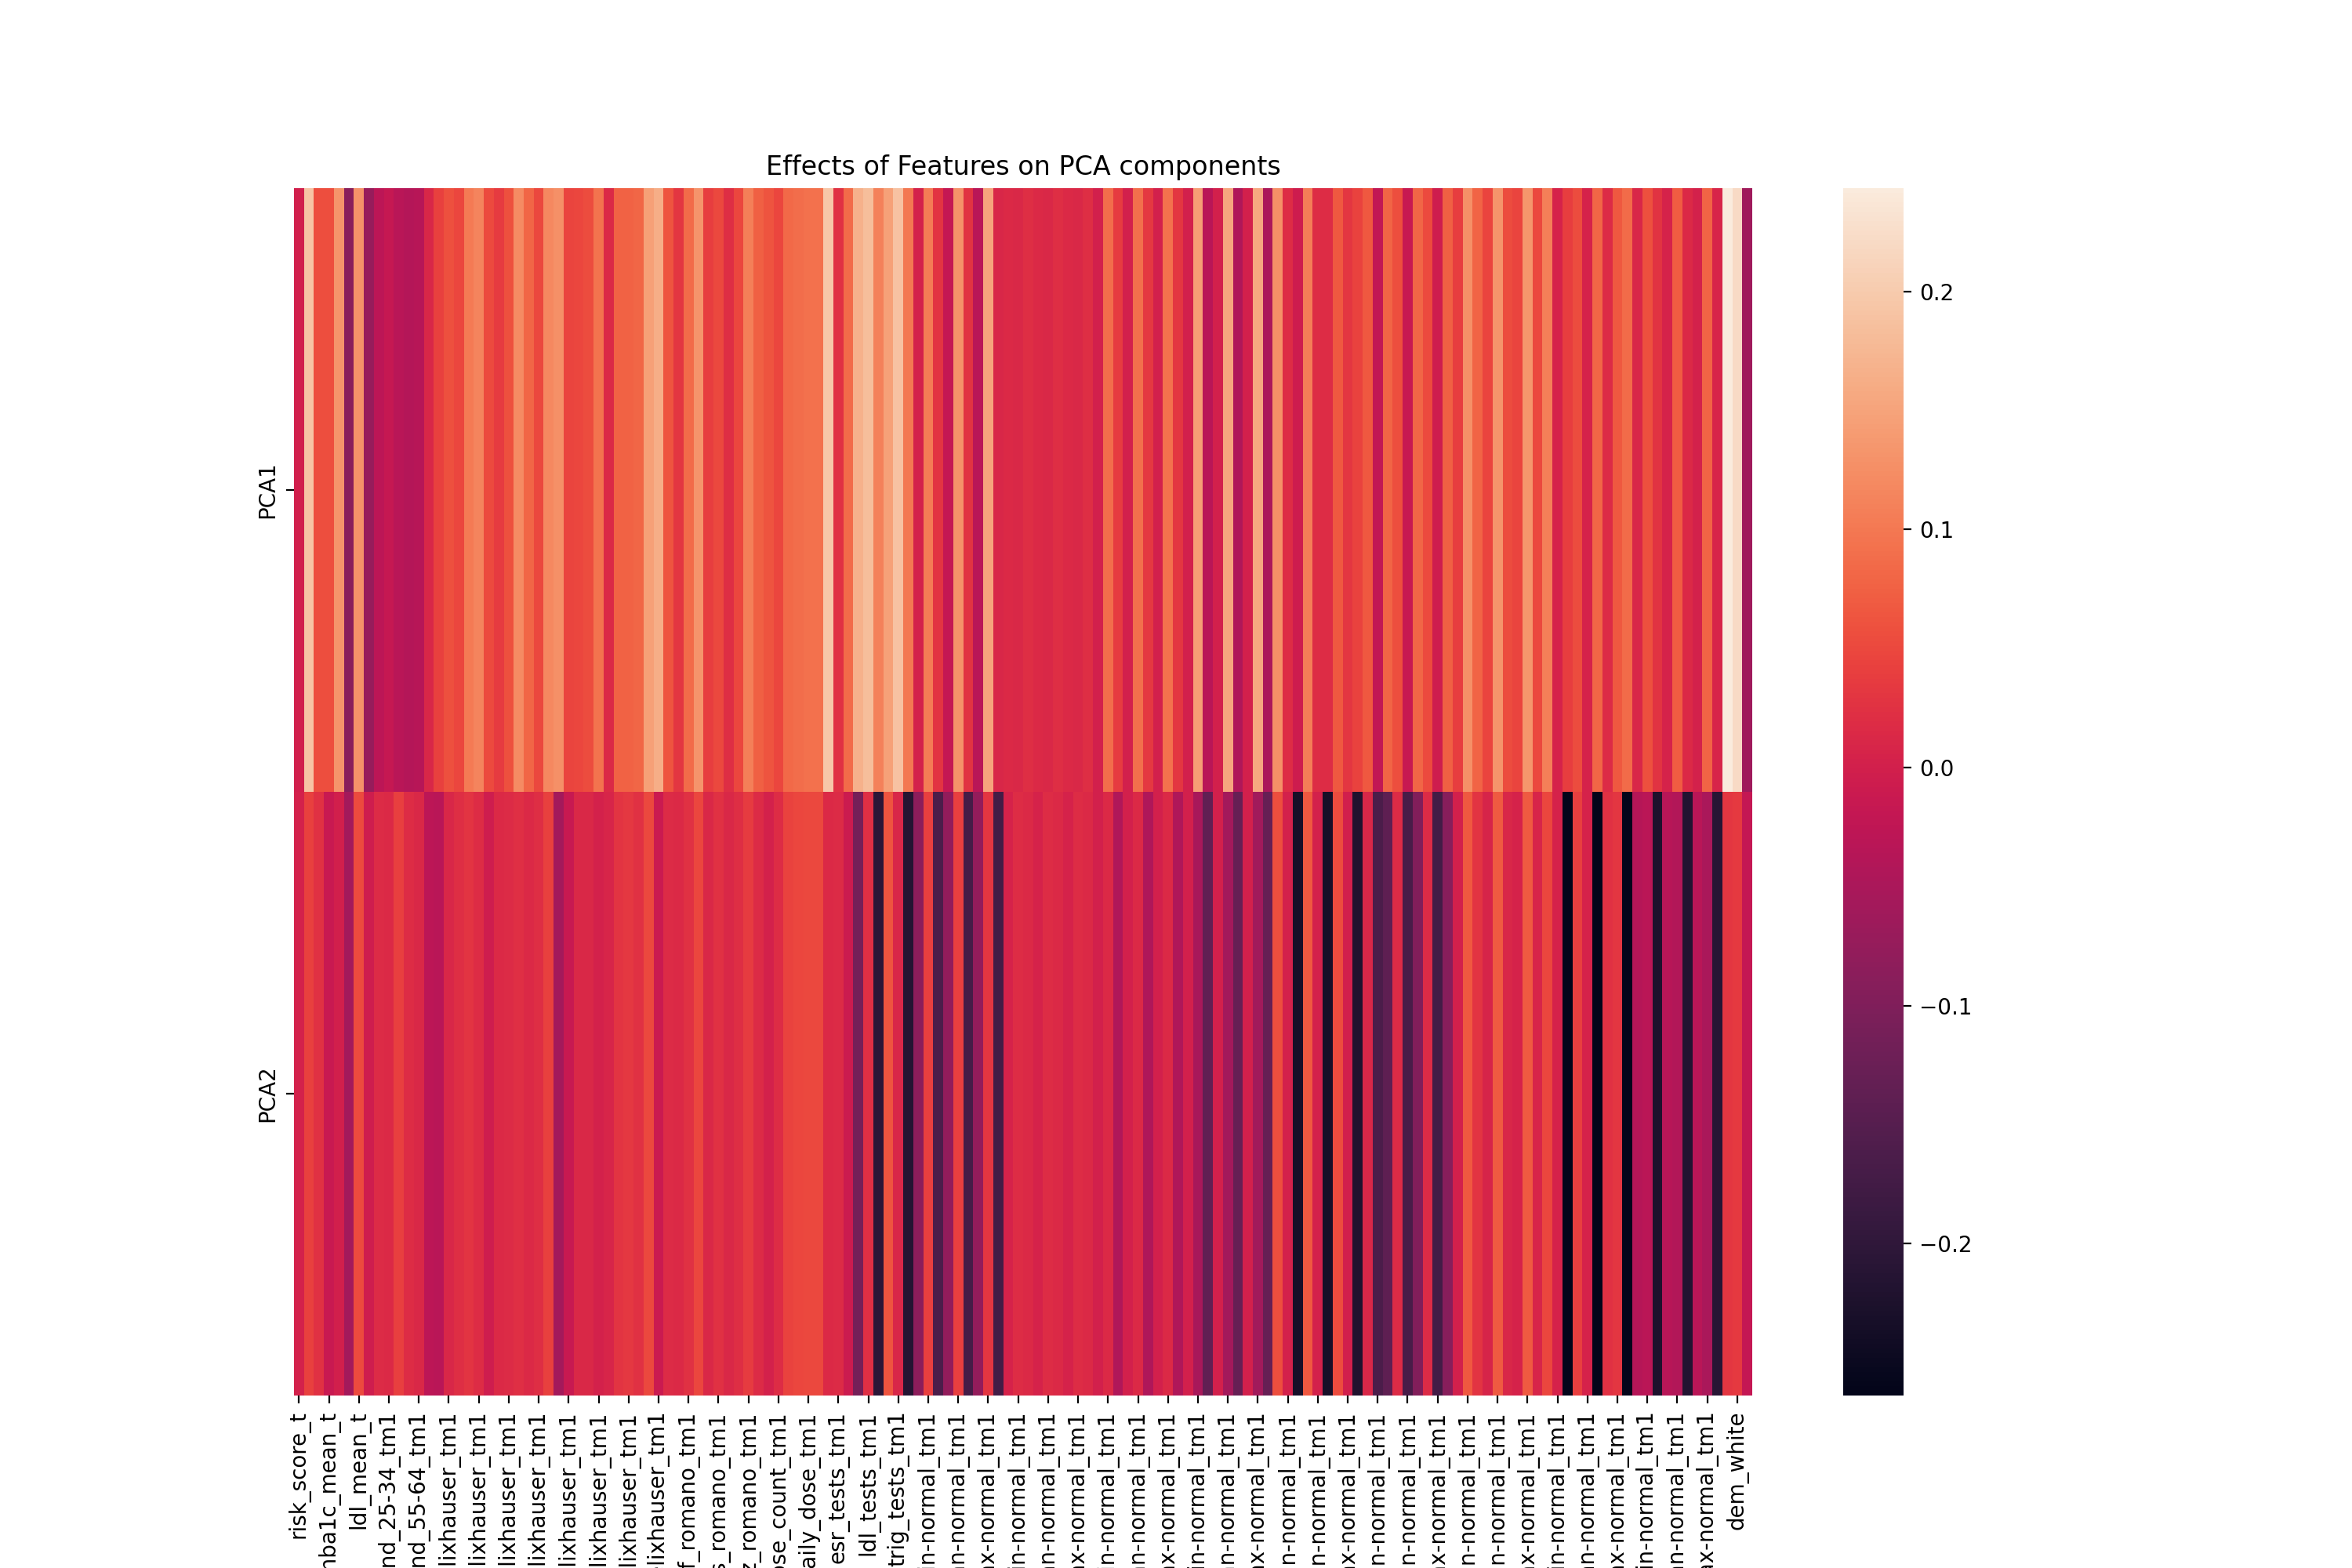

In [109]:
#https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/

# With all variables besides cost-related

copy_df = data_df.copy()
drop_columns = copy_df.filter(like='cost').columns
copy_df = copy_df.drop(columns = drop_columns)
others = ['race', 'dem_gender']
copy_df = copy_df.drop(columns = others)
data_subset = copy_df.dropna()

# Standardize
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_subset)

# Optimal number of clusters using the Elbow method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

# Based on the Elbow curve
optimal_k = 4

# Apply kMeans clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
data_subset['cluster'] = kmeans.fit_predict(scaled_data)

# Visualization
plt.scatter(data_subset['risk_score_t'], data_subset['gagne_sum_t'], c=data_subset['cluster'], cmap='viridis')
plt.title('kMeans Clusters')
plt.xlabel('Previous Risk Score')
plt.ylabel('Active illnesses mean')
plt.show()


pca=PCA(n_components=2)
reduced_X=pd.DataFrame(data=pca.fit_transform(scaled_data),columns=['PCA1','PCA2'])

plt.figure(figsize=(7,5))

centers = pca.transform(kmeans.cluster_centers_)

# Scatter plot
plt.scatter(reduced_X['PCA1'],reduced_X['PCA2'],c=kmeans.labels_)
plt.scatter(centers[:,0],centers[:,1],marker='x',s=100,c='red')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Cluster')
plt.tight_layout()
plt.show()

col = []
for c in data_subset.columns:
  if c == "index":
    continue
  else:
    col.append(c)

# Represent the effect Features on PCA components
# plt.figure(figsize=(100,5))
components=pd.DataFrame(pca.components_,index=['PCA1',"PCA2"],columns=col)
print(components)
plt.figure(figsize = (15,10))
sns.heatmap(components)
plt.title("Effects of Features on PCA components")
plt.show()

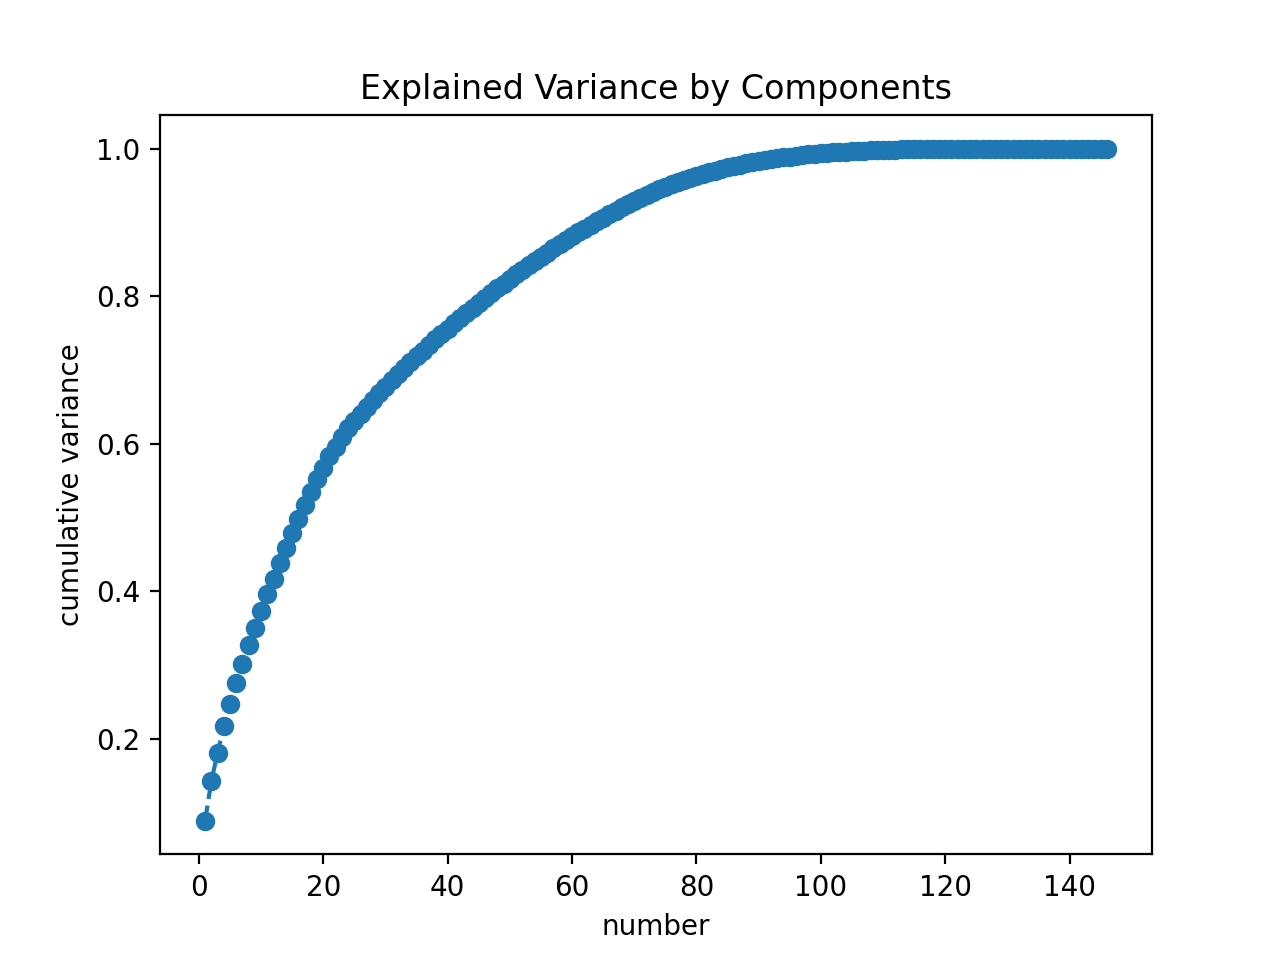

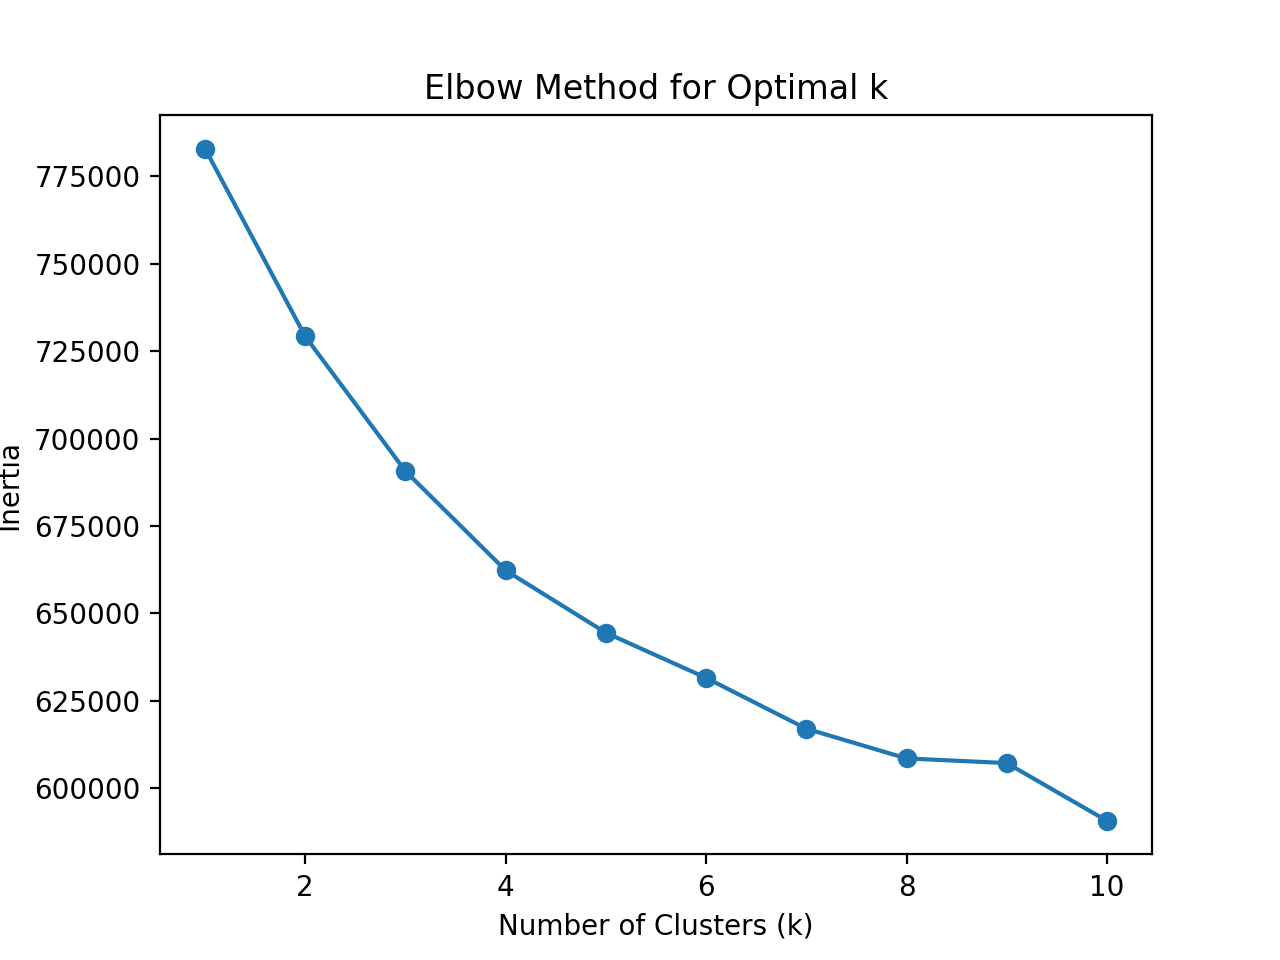

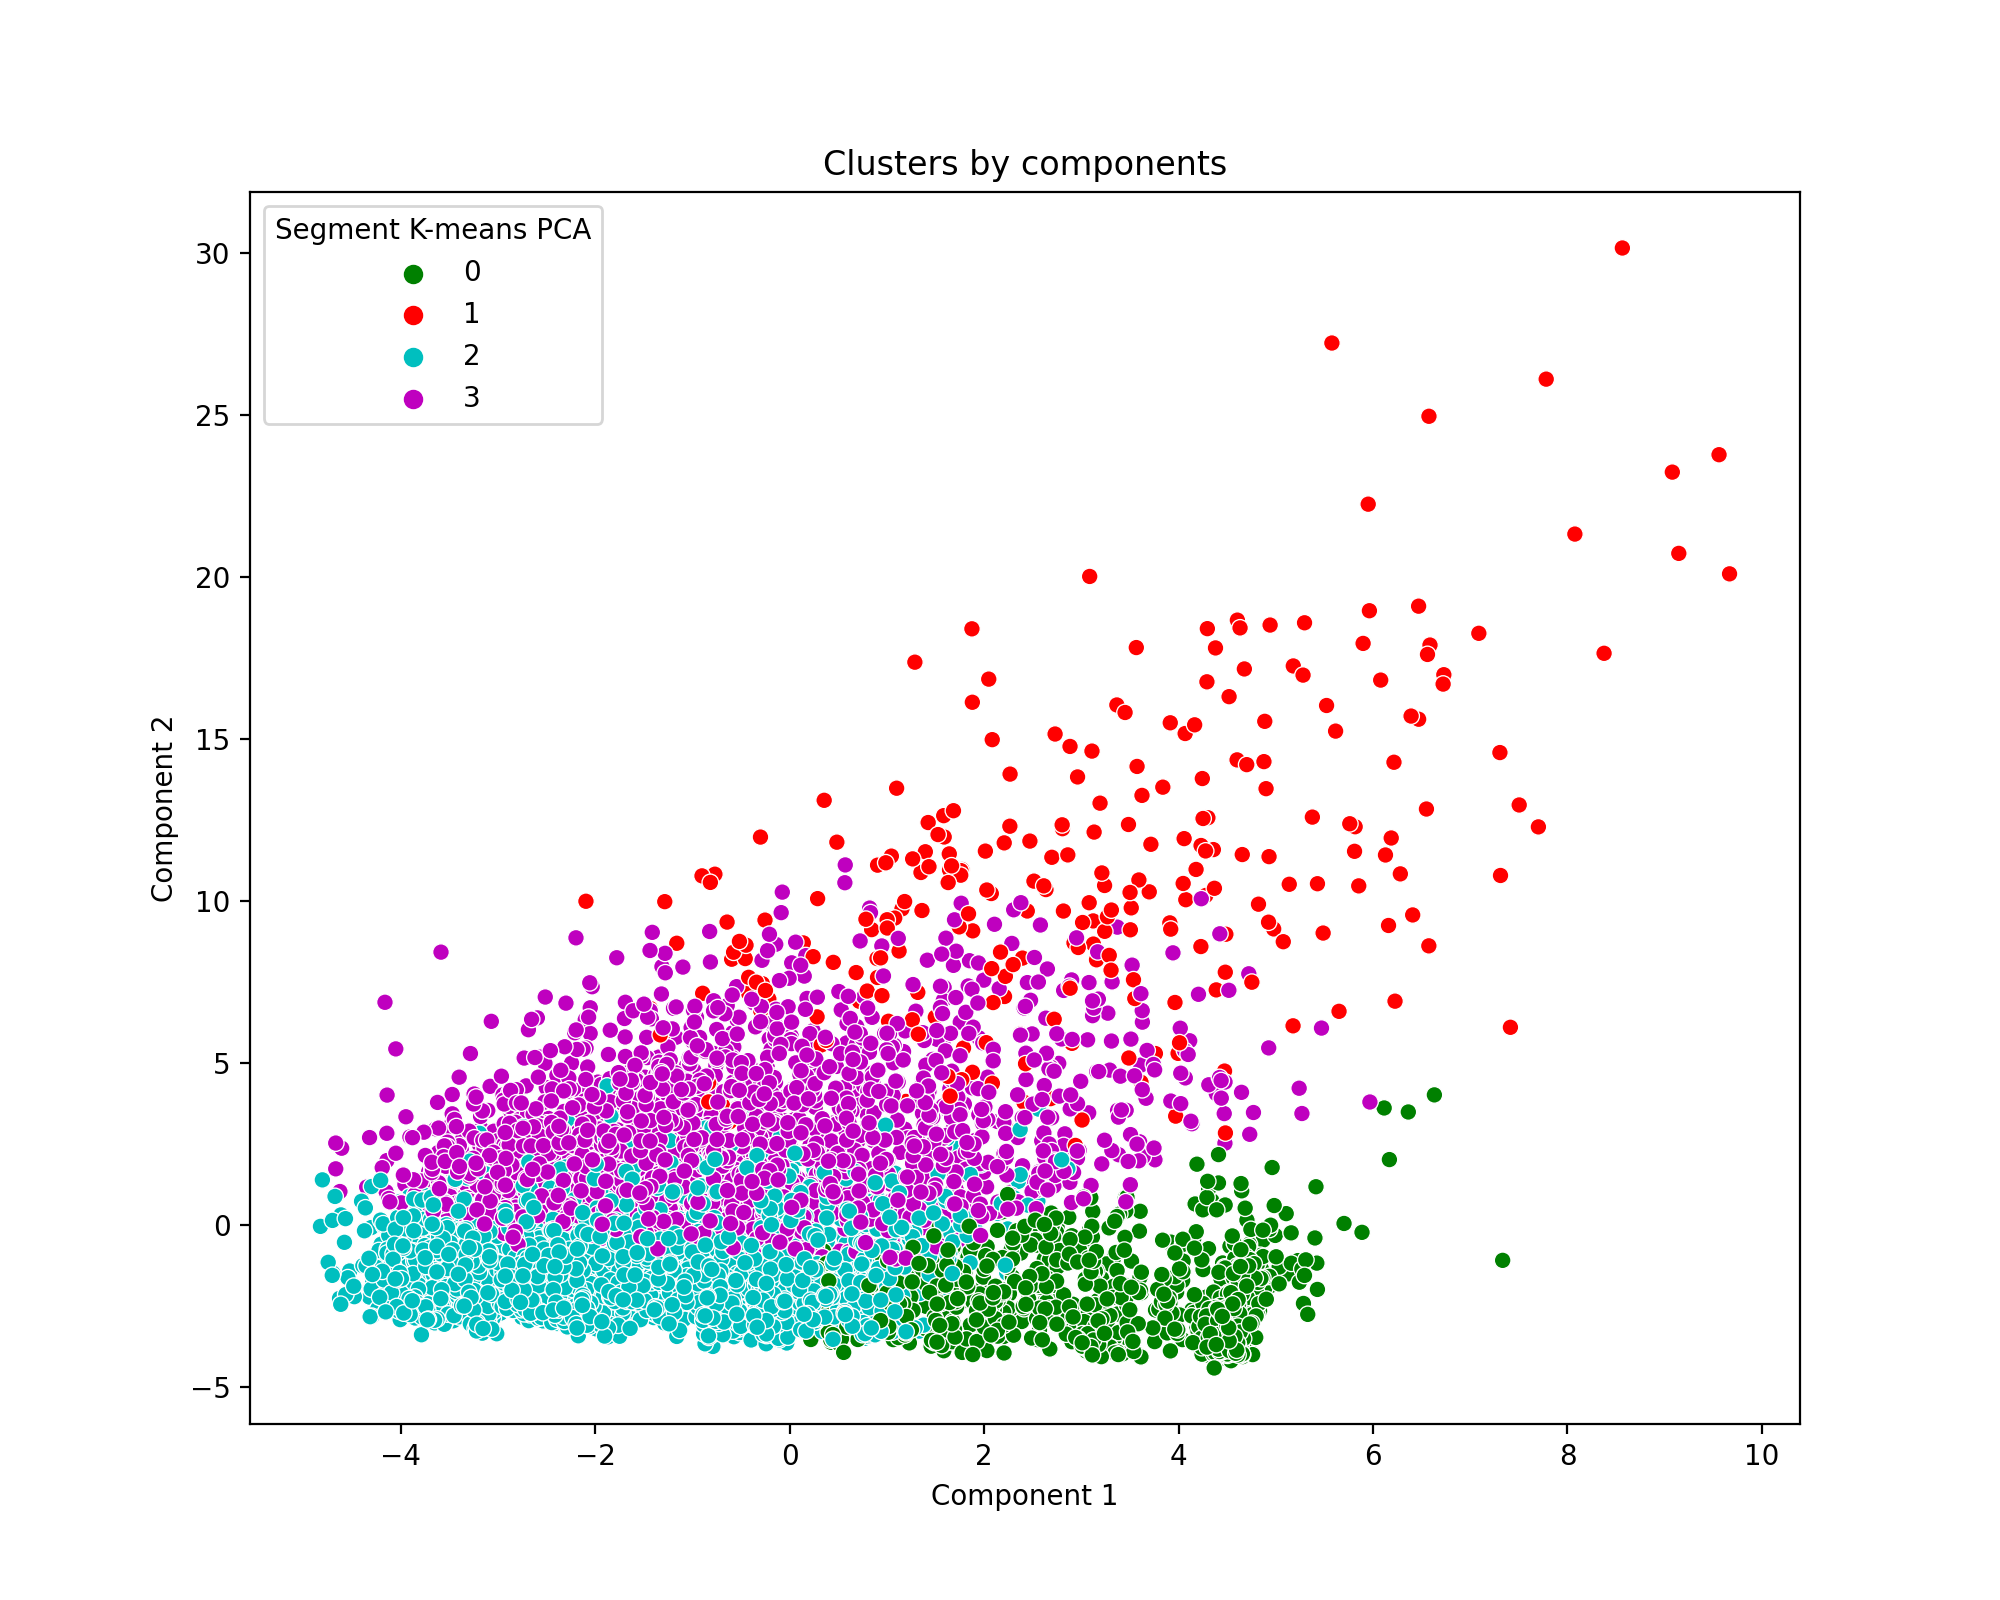

In [110]:
#https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/

# With all variables besides cost-related

copy_df = data_df.copy()
drop_columns = copy_df.filter(like='cost').columns
copy_df = copy_df.drop(columns = drop_columns)
others = ['race', 'dem_gender']
copy_df = copy_df.drop(columns = others)
data_subset = copy_df.dropna()

# Standardize
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_subset)

# Fitting the data
pca = PCA()
pca.fit(scaled_data)

plt.plot(range(1,147), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Explained Variance by Components')
plt.xlabel('number')
plt.ylabel('cumulative variance')
plt.show()


pca=PCA(n_components = 48)
pca.fit(scaled_data)
scores_pca = pca.transform(scaled_data)

# Optimal number of clusters using the Elbow method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(scores_pca)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

# Based on the Elbow curve
optimal_k = 4

# # Apply kMeans clustering
kmeans_pca = KMeans(n_clusters=optimal_k, random_state=42, init = 'k-means++', n_init='auto')
# data_subset['cluster'] = kmeans.fit_predict(scaled_data)
kmeans_pca.fit(scores_pca)


df_pca = pd.concat([data_subset.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)
for i in range(147,0,-1):
  col_name = "Comp " + str(i)
  df_pca.columns.values[-i] = col_name

df_pca["Segment K-means PCA"] = kmeans_pca.labels_

x_axis = df_pca['Comp 47']
y_axis = df_pca['Comp 48']

plt.figure(figsize = (10,8))
sns.scatterplot(x = x_axis, y = y_axis, hue = df_pca["Segment K-means PCA"], palette = ['g','r','c', 'm'])
plt.title('Clusters by components')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()


#stop

In [111]:
# Correlation Analysis
copy_df = data_df.copy()
drop_columns = copy_df.filter(like='cost').columns
copy_df = copy_df.drop(columns = drop_columns)

correlation_matrix = copy_df.corr(numeric_only = True)
correlation_with_risk_score = correlation_matrix['risk_score_t'].sort_values(ascending=False)
print("Correlation with risk_score:")
print(correlation_with_risk_score.head(40))

Correlation with risk_score:
risk_score_t                     1.000000
gagne_sum_tm1                    0.617634
gagne_sum_t                      0.570211
cre_tests_tm1                    0.482977
sodium_tests_tm1                 0.476917
hct_tests_tm1                    0.473747
cre_mean_t                       0.416817
renal_elixhauser_tm1             0.358616
chf_romano_tm1                   0.327797
hct_min-low_tm1                  0.320029
electrolytes_elixhauser_tm1      0.315403
hypertension_elixhauser_tm1      0.315020
nt_bnp_tests_tm1                 0.308506
cre_max-high_tm1                 0.308128
arrhythmia_elixhauser_tm1        0.298851
tumor_romano_tm1                 0.283797
sodium_min-low_tm1               0.283098
nt_bnp_max-high_tm1              0.276987
uncompdiabetes_elixhauser_tm1    0.273071
hct_mean-low_tm1                 0.270033
anemia_elixhauser_tm1            0.269525
cre_mean-high_tm1                0.266852
nt_bnp_mean-high_tm1             0.265298
nt_bn

In [112]:
# Other methods to see feature importance
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

data_df2 = data_df.copy()
data_df3 = data_df2.dropna(axis=1)
data_df3 = data_df3.drop(['race', 'dem_gender'], axis=1)
drop_columns = data_df3.filter(like='cost').columns
data_df3 = data_df3.drop(columns = drop_columns)

data_df3['risk_score_category'] = pd.cut(data_df3['risk_score_t'], bins=3, labels=[0, 1, 2])

# Separate features (X) and target variable (y)
X = data_df3.drop(['risk_score_t', 'risk_score_category'], axis=1)
y = data_df3['risk_score_category']

# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X, y)
feature_importances_rf = pd.Series(rf_model.feature_importances_, index=X.columns)

# XGBoost
xgb_model = XGBClassifier()
xgb_model.fit(X, y)
feature_importances_xgb = pd.Series(xgb_model.feature_importances_, index=X.columns)

print("Random Forest Feature Importances:")
print(feature_importances_rf.sort_values(ascending=False))
print("\nXGBoost Feature Importances:")
print(feature_importances_xgb.sort_values(ascending=False))

Random Forest Feature Importances:
index                  0.058472
gagne_sum_tm1          0.049101
gagne_sum_t            0.047146
sodium_tests_tm1       0.043105
cre_tests_tm1          0.042206
                         ...   
esr_mean-low_tm1       0.000000
esr_max-low_tm1        0.000000
ghba1c_min-low_tm1     0.000000
ghba1c_mean-low_tm1    0.000000
ghba1c_max-low_tm1     0.000000
Length: 140, dtype: float64

XGBoost Feature Importances:
gagne_sum_tm1          0.049917
trig_max-low_tm1       0.020809
cre_mean-normal_tm1    0.019897
trig_mean-low_tm1      0.015083
dem_white              0.014820
                         ...   
esr_min-low_tm1        0.000000
esr_mean-low_tm1       0.000000
esr_max-low_tm1        0.000000
ghba1c_min-low_tm1     0.000000
crp_mean-normal_tm1    0.000000
Length: 140, dtype: float32


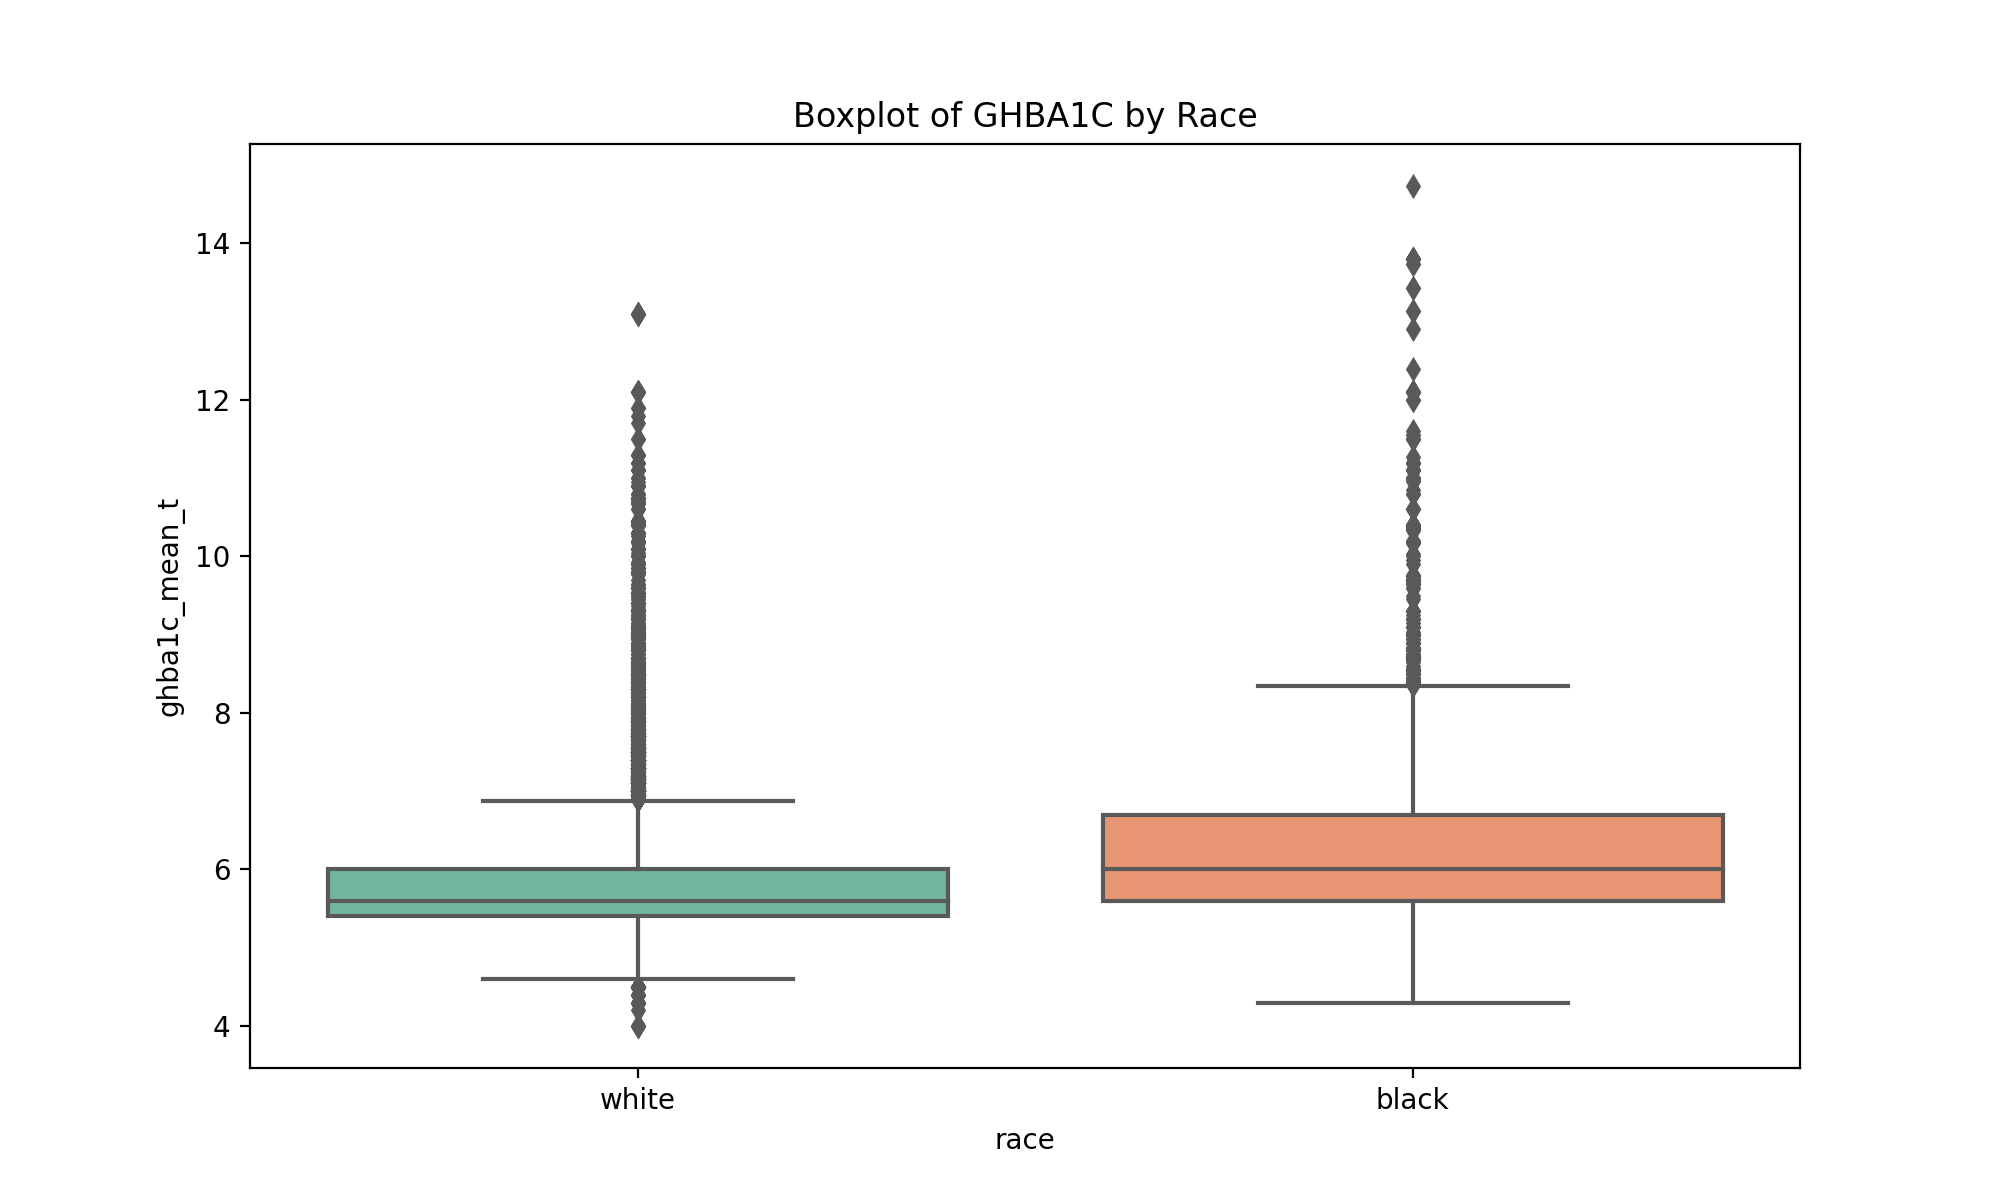

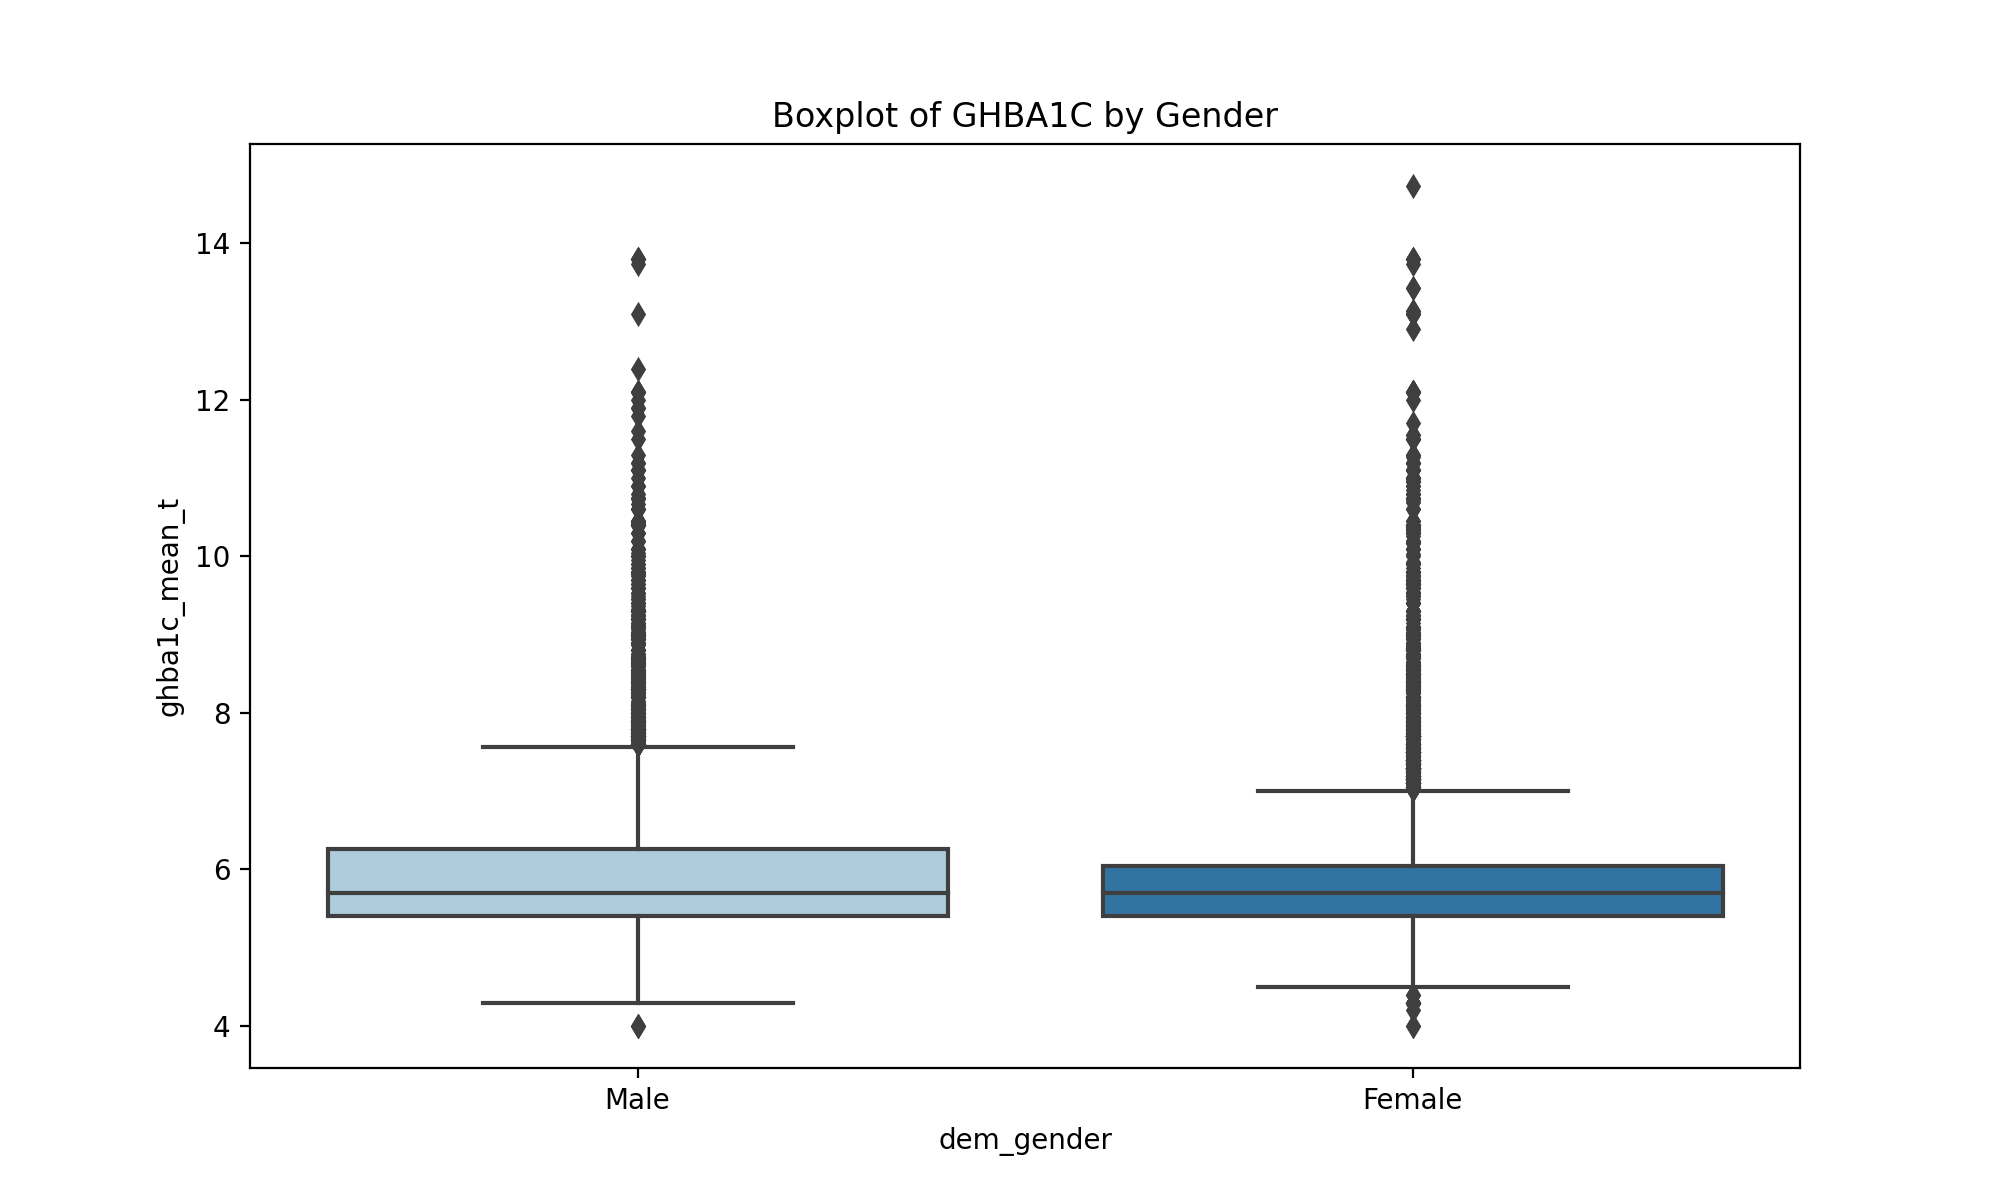

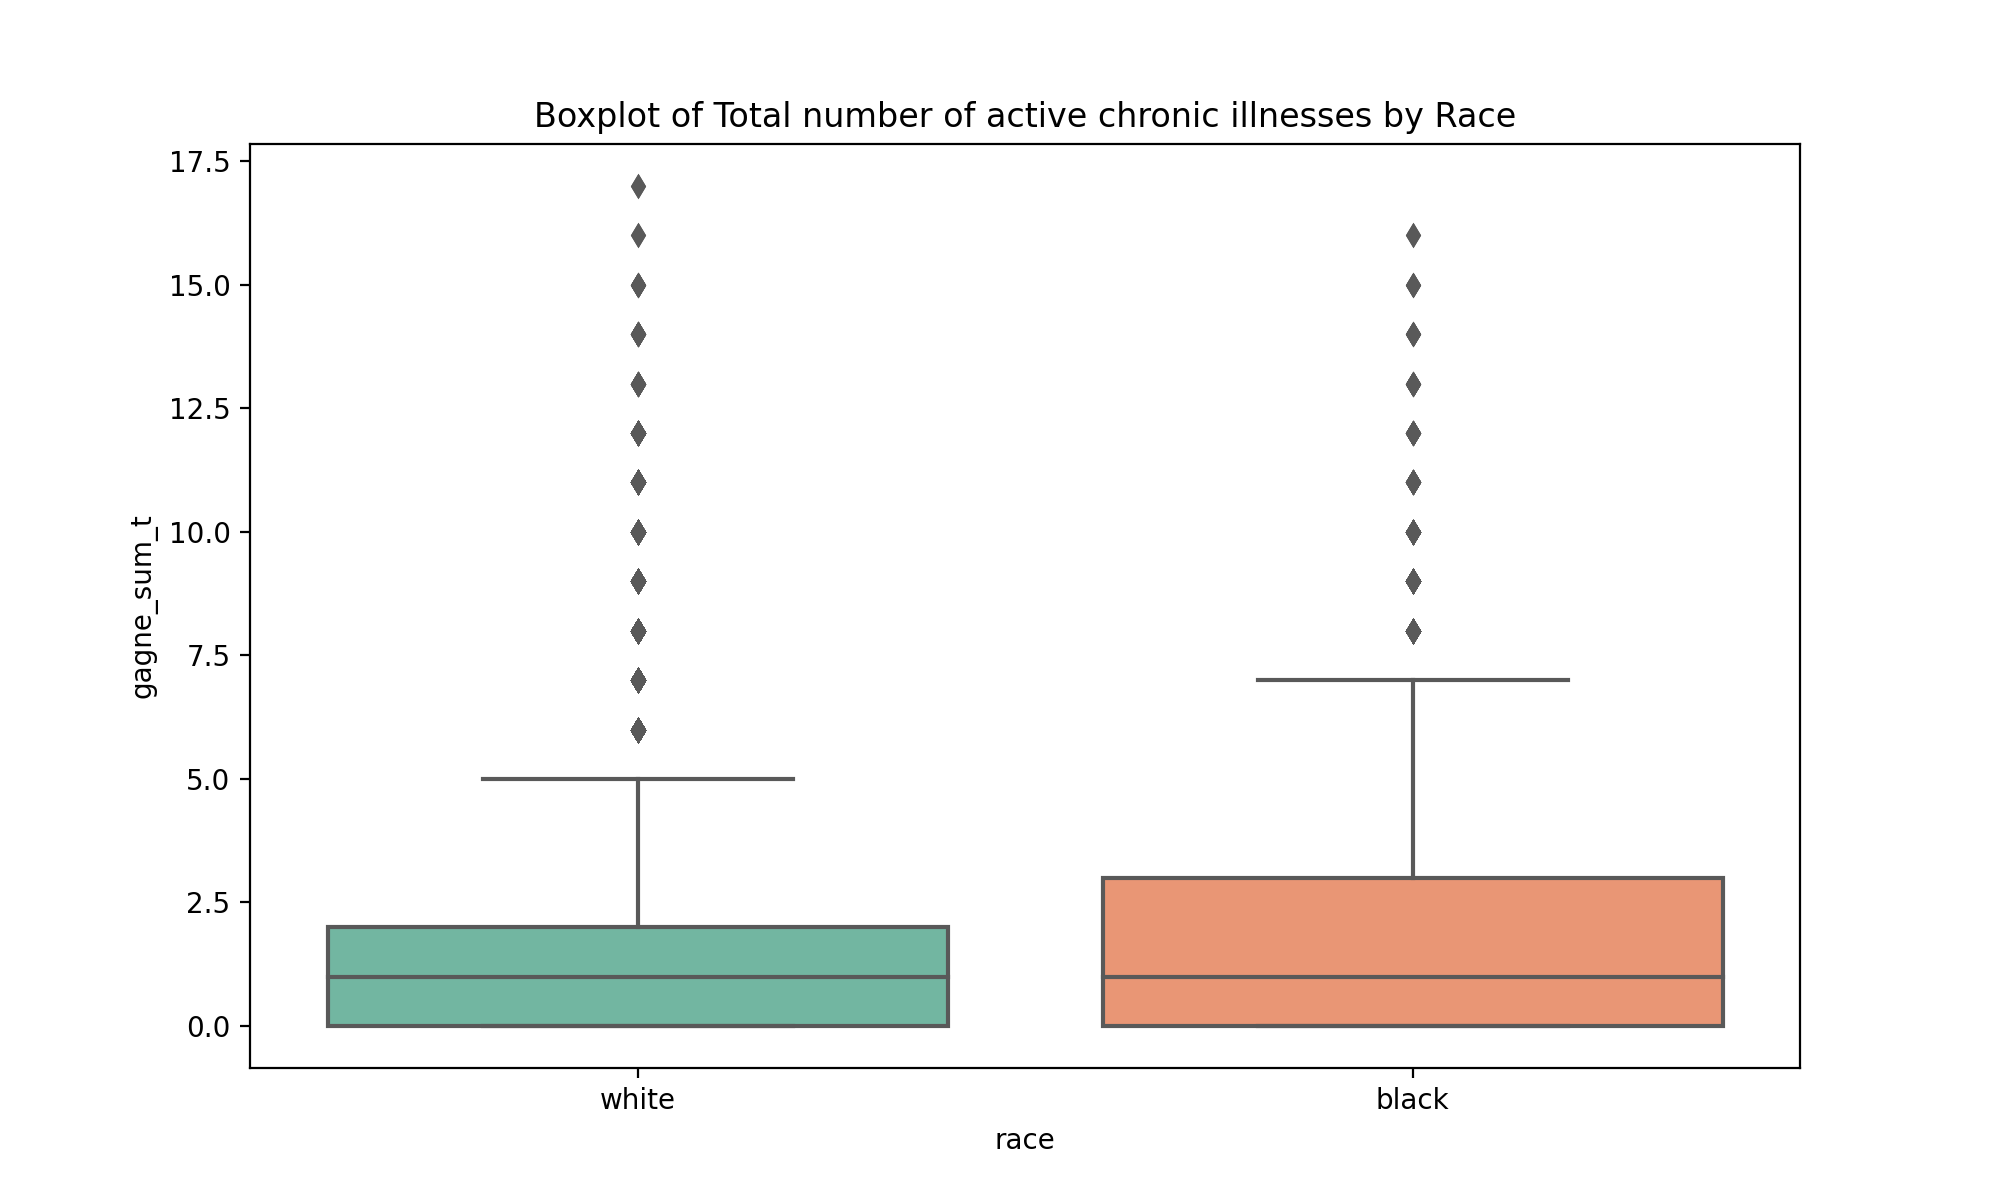

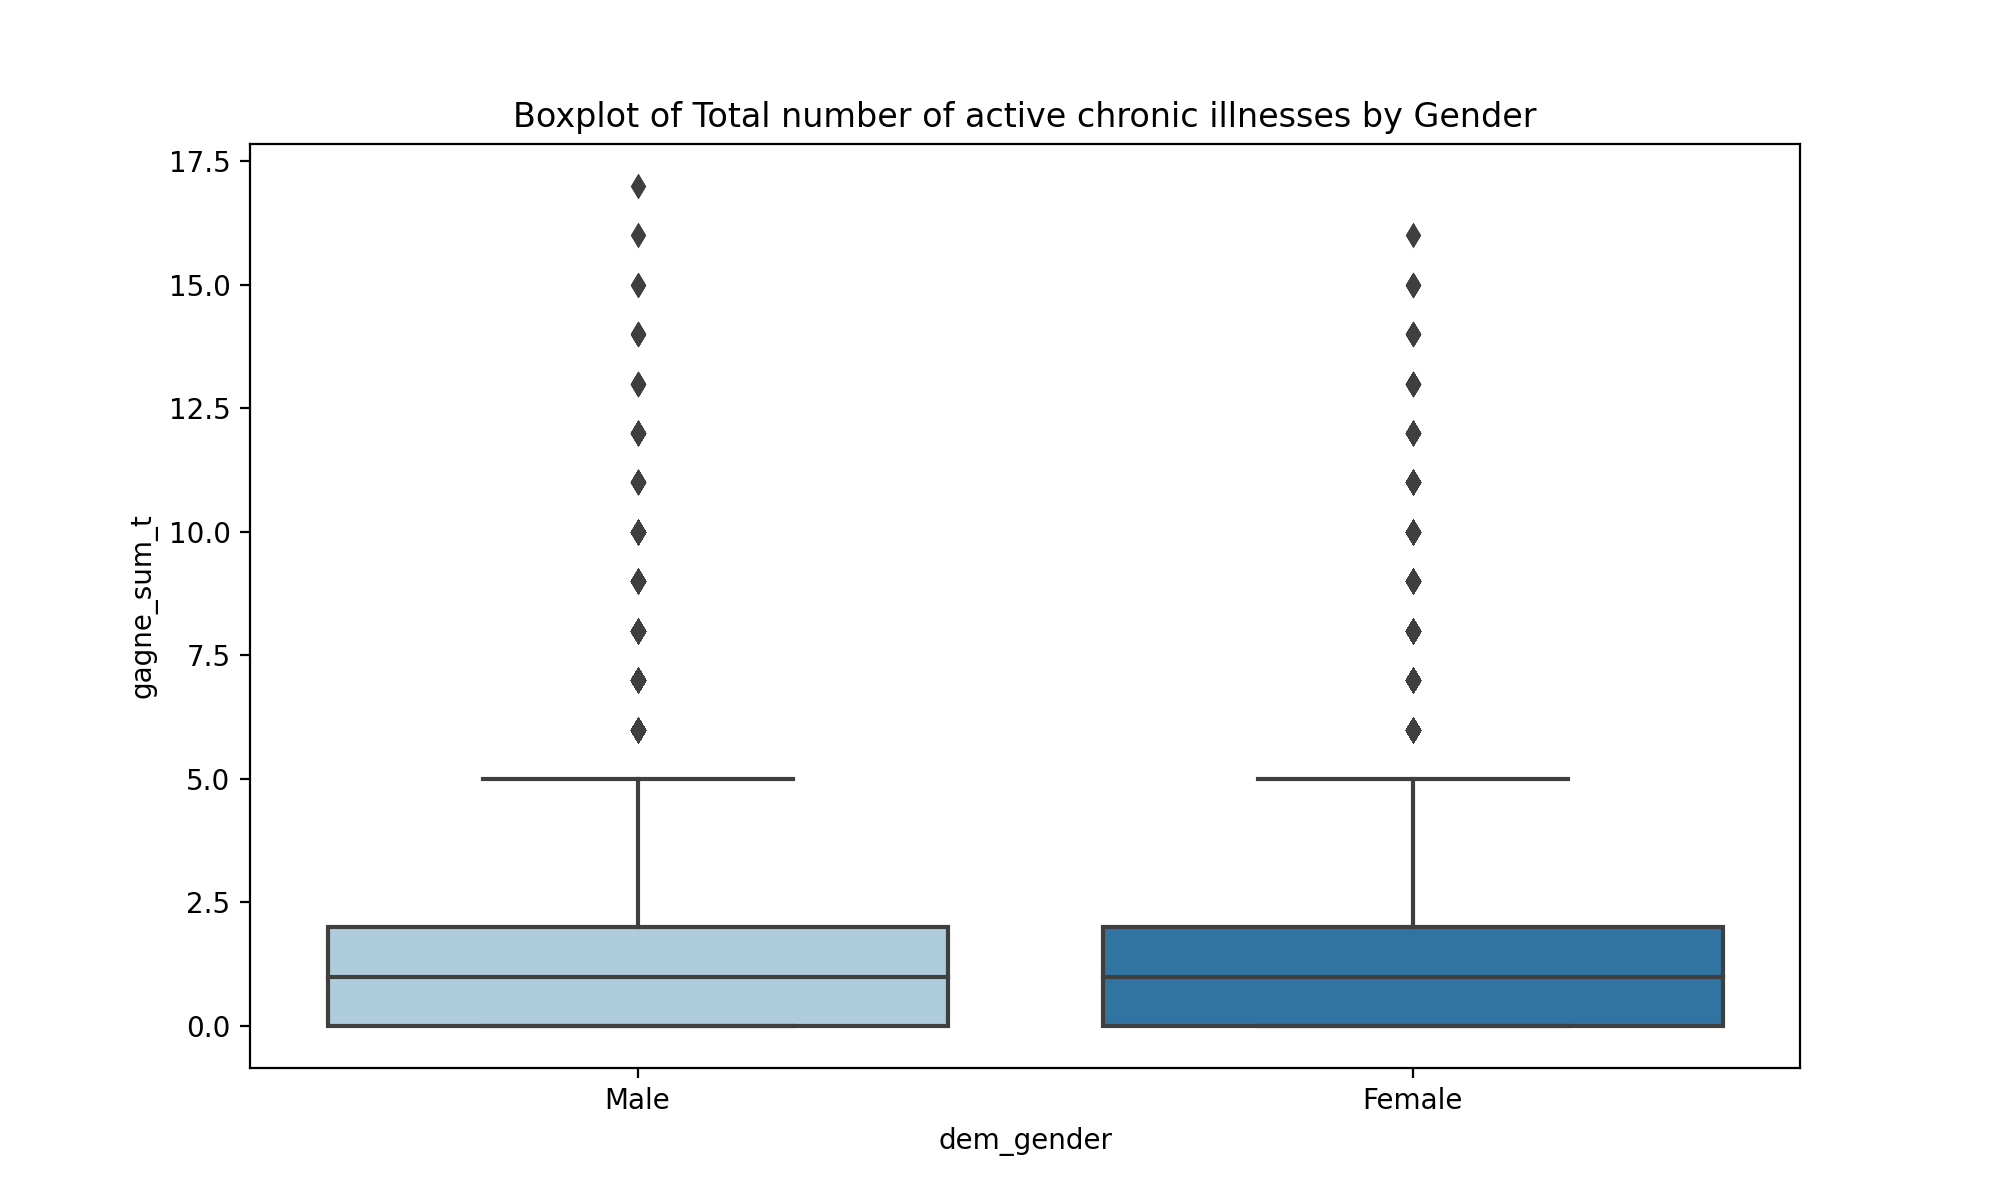

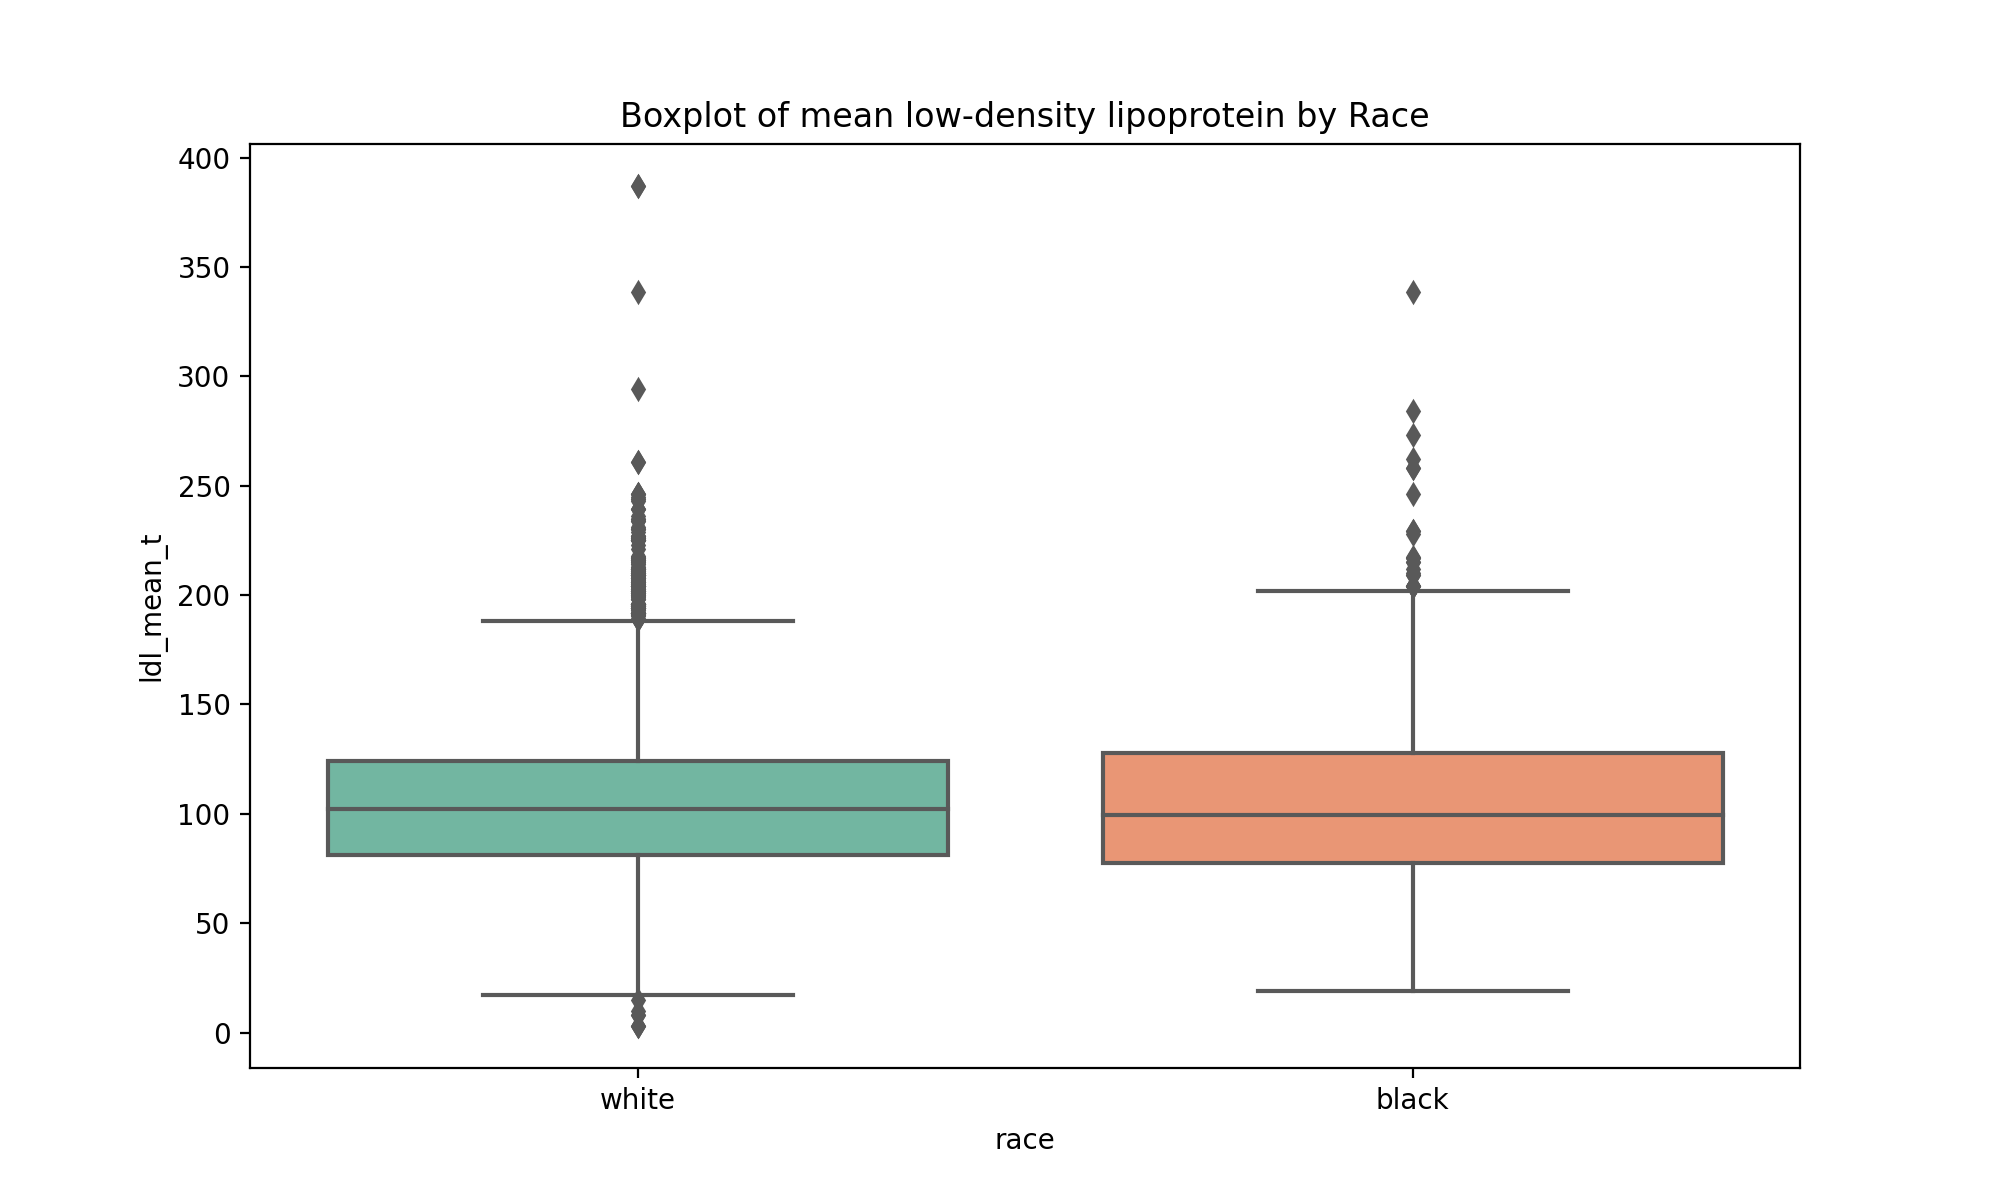

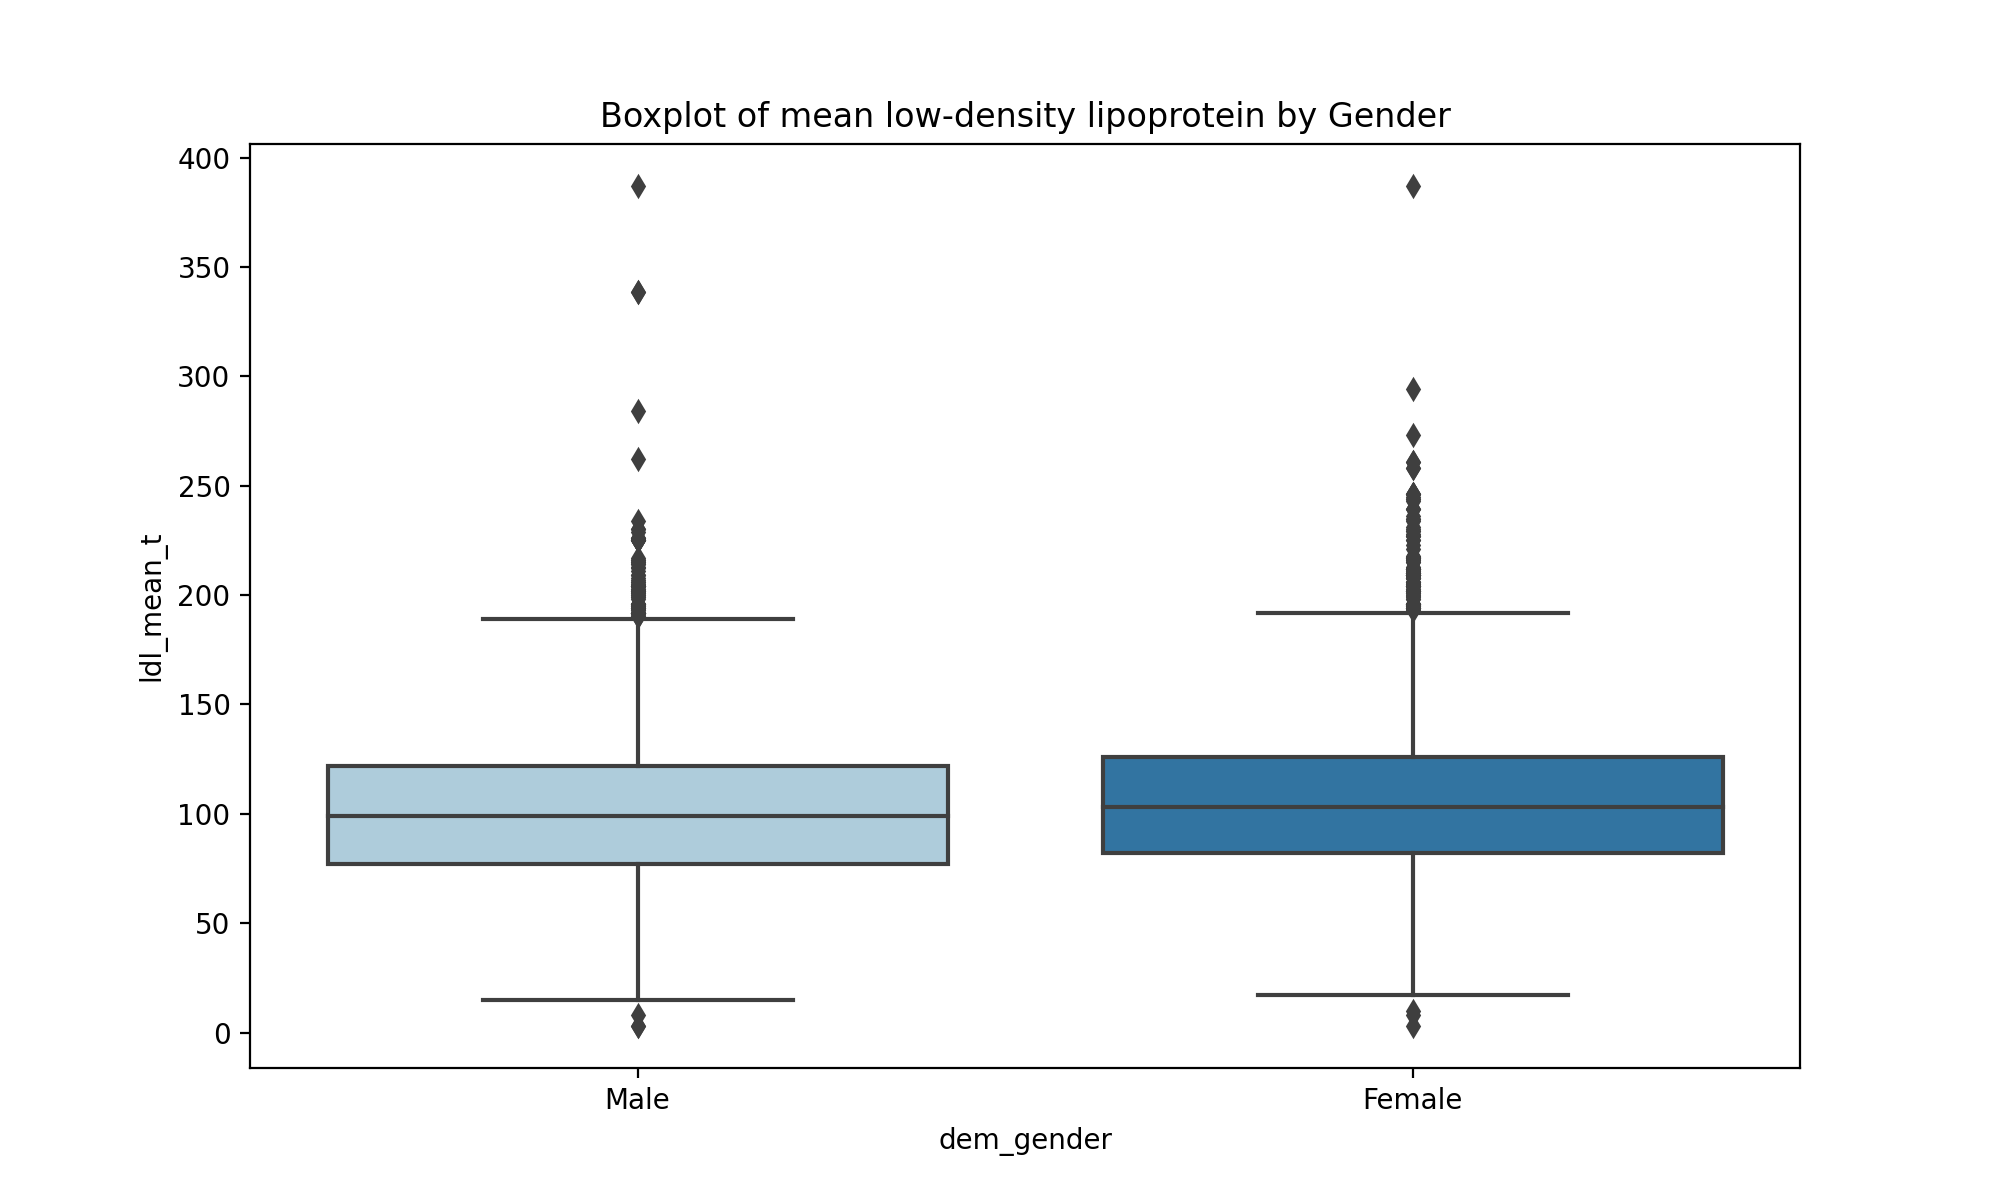

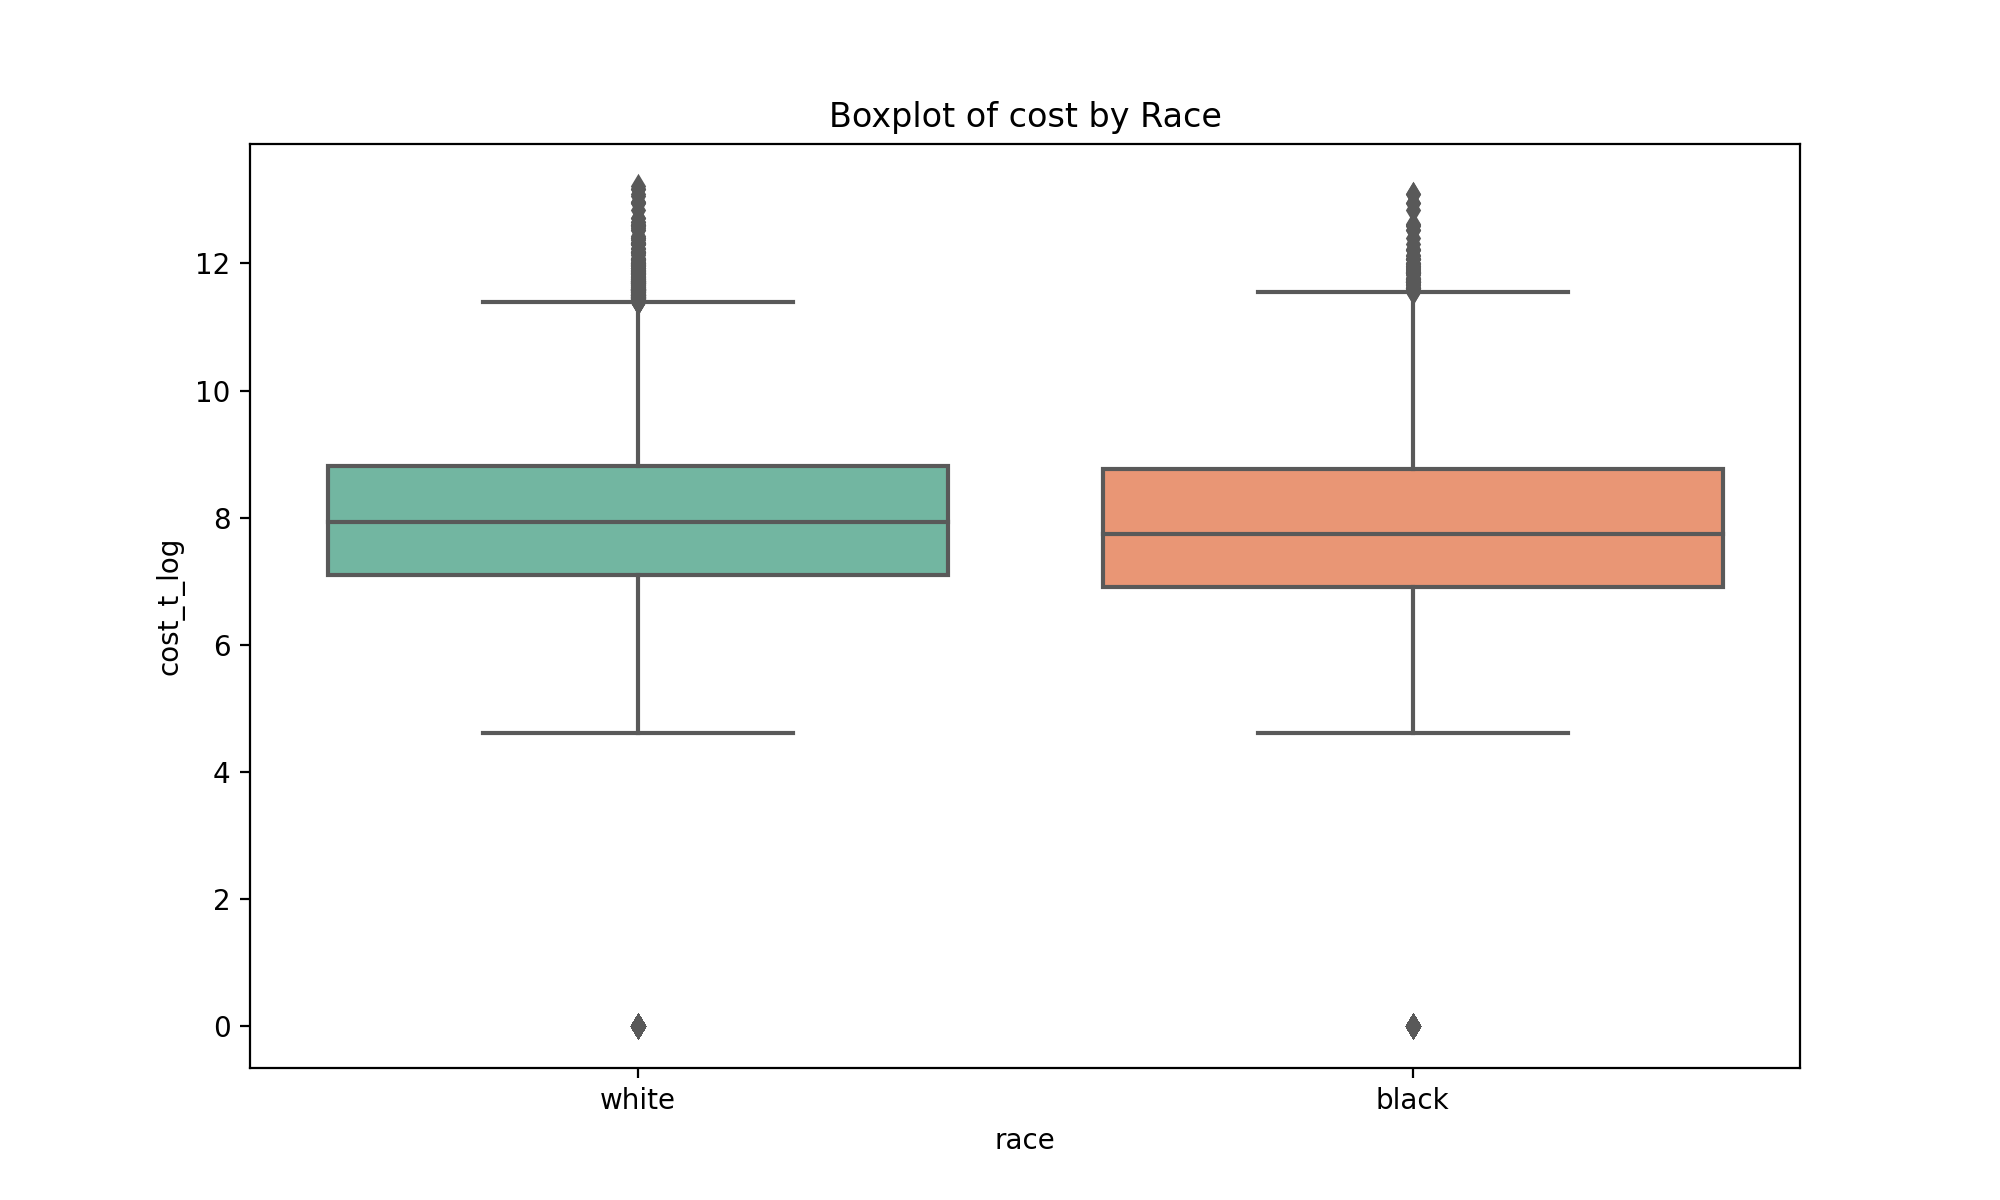

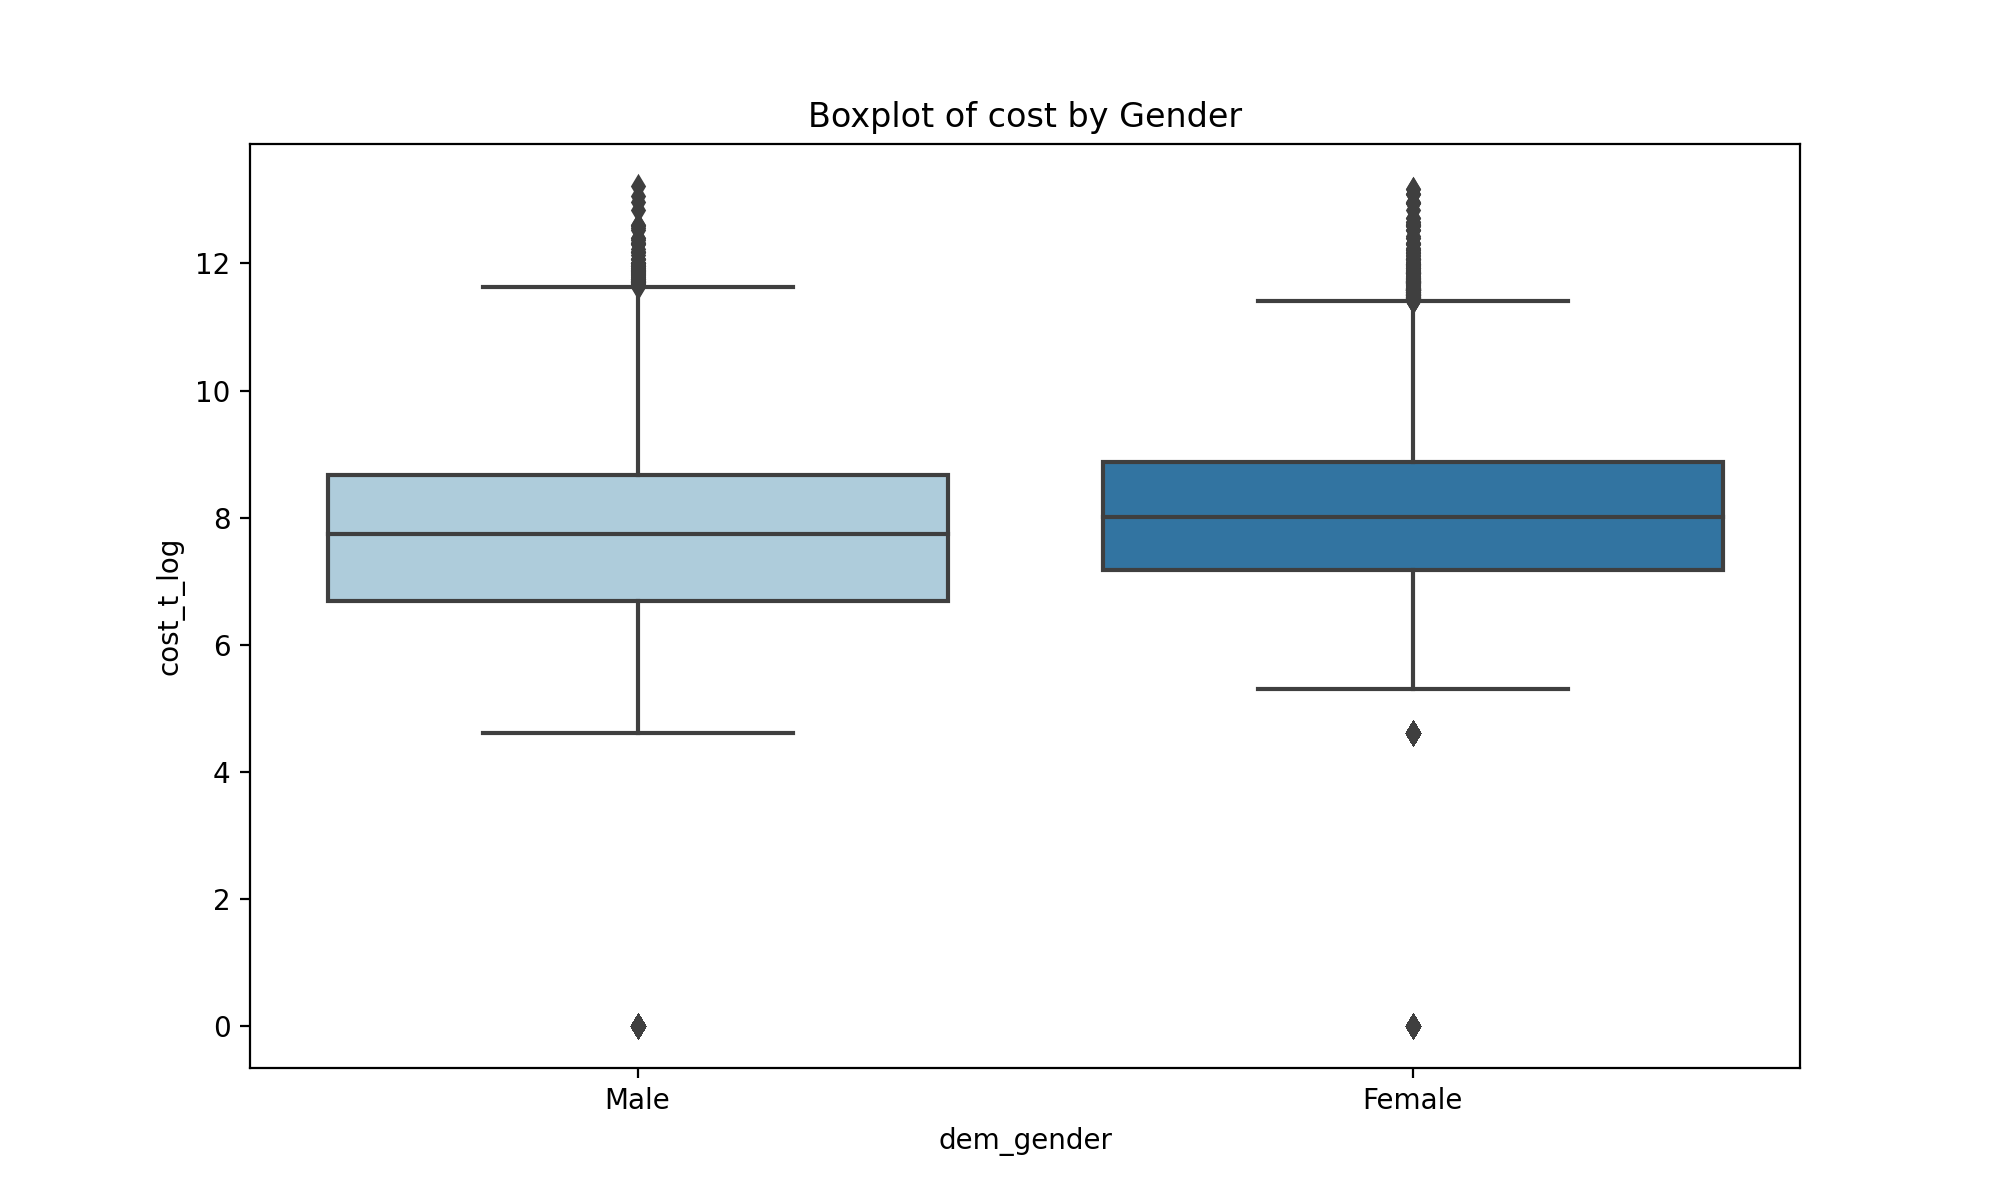

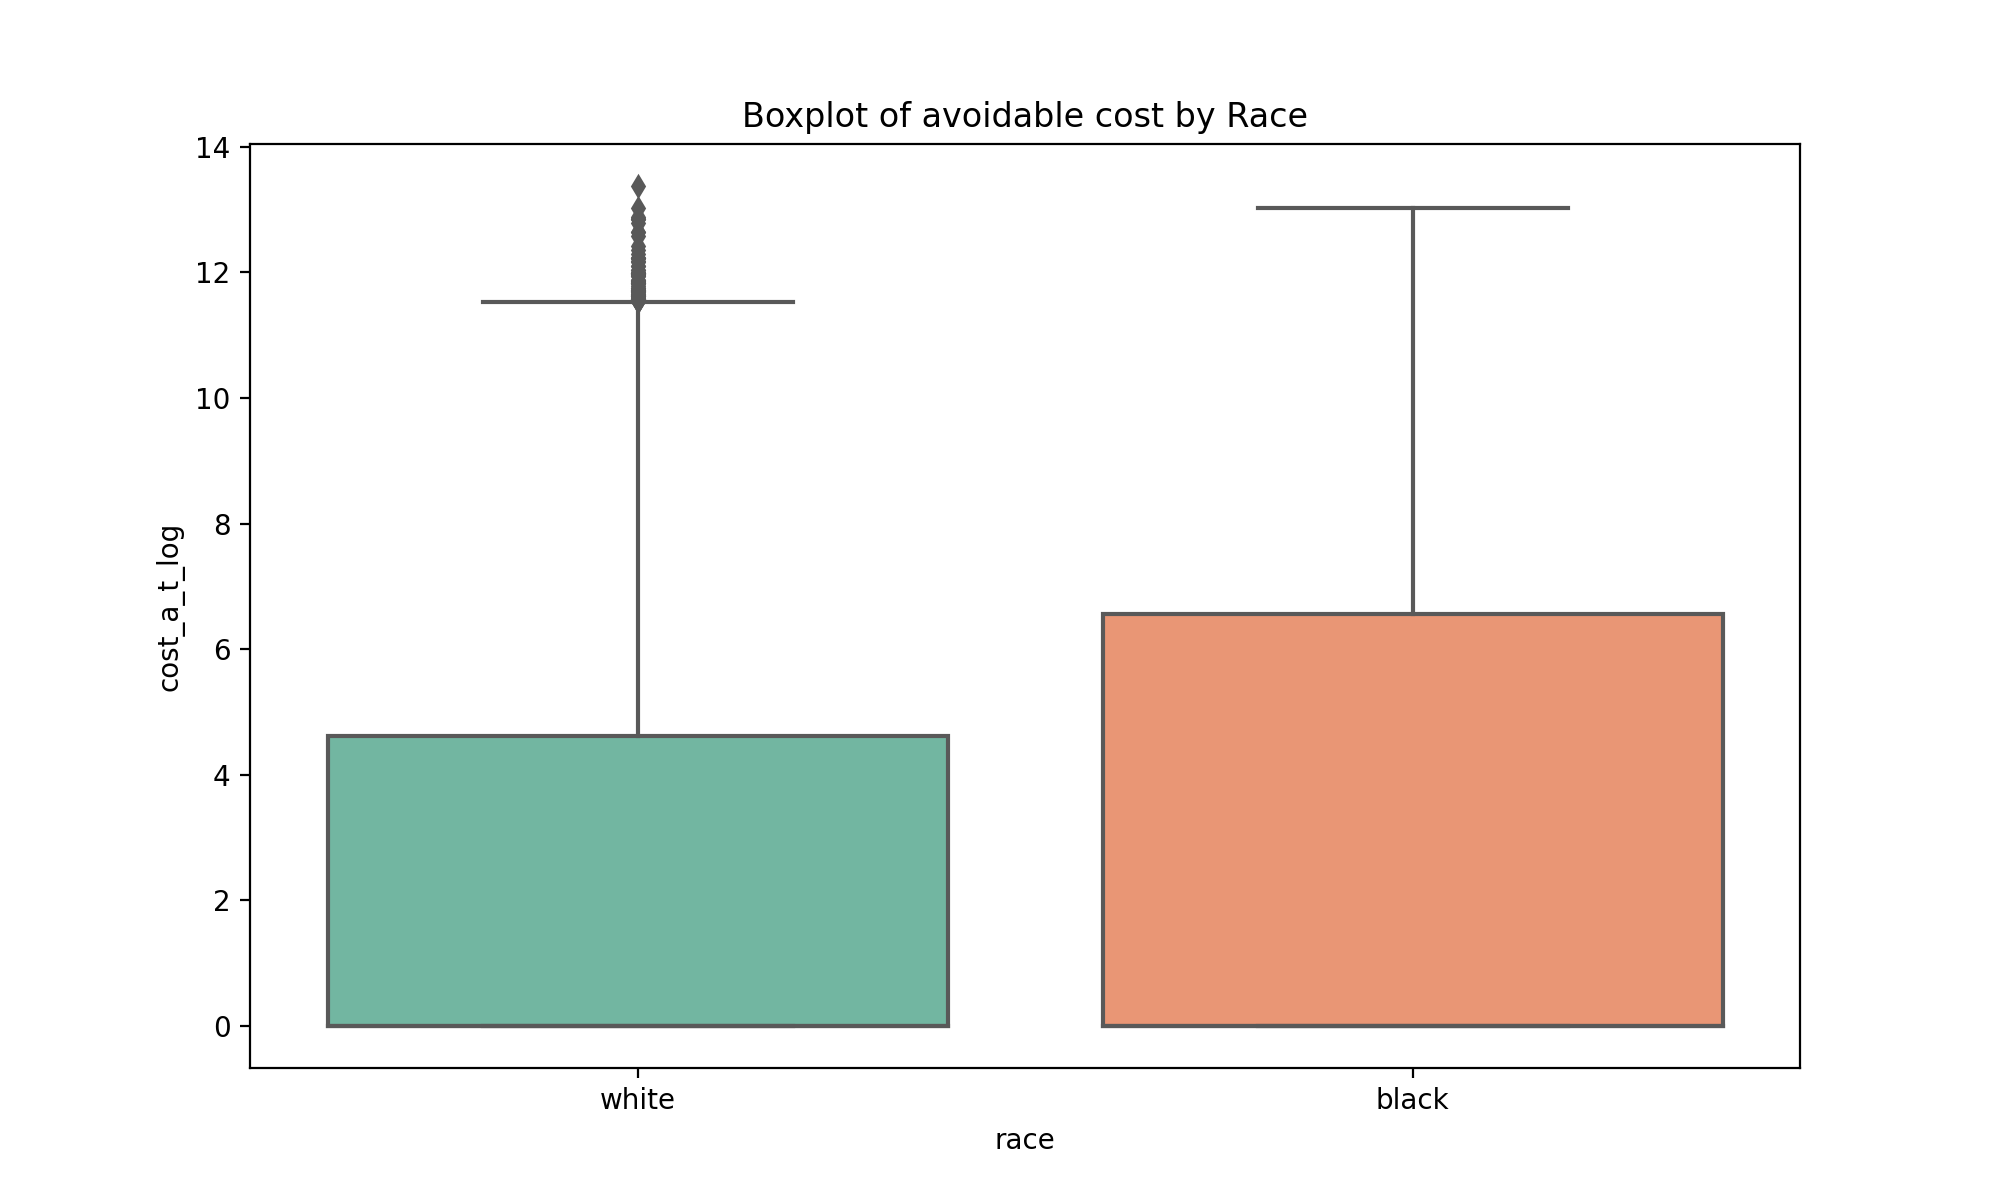

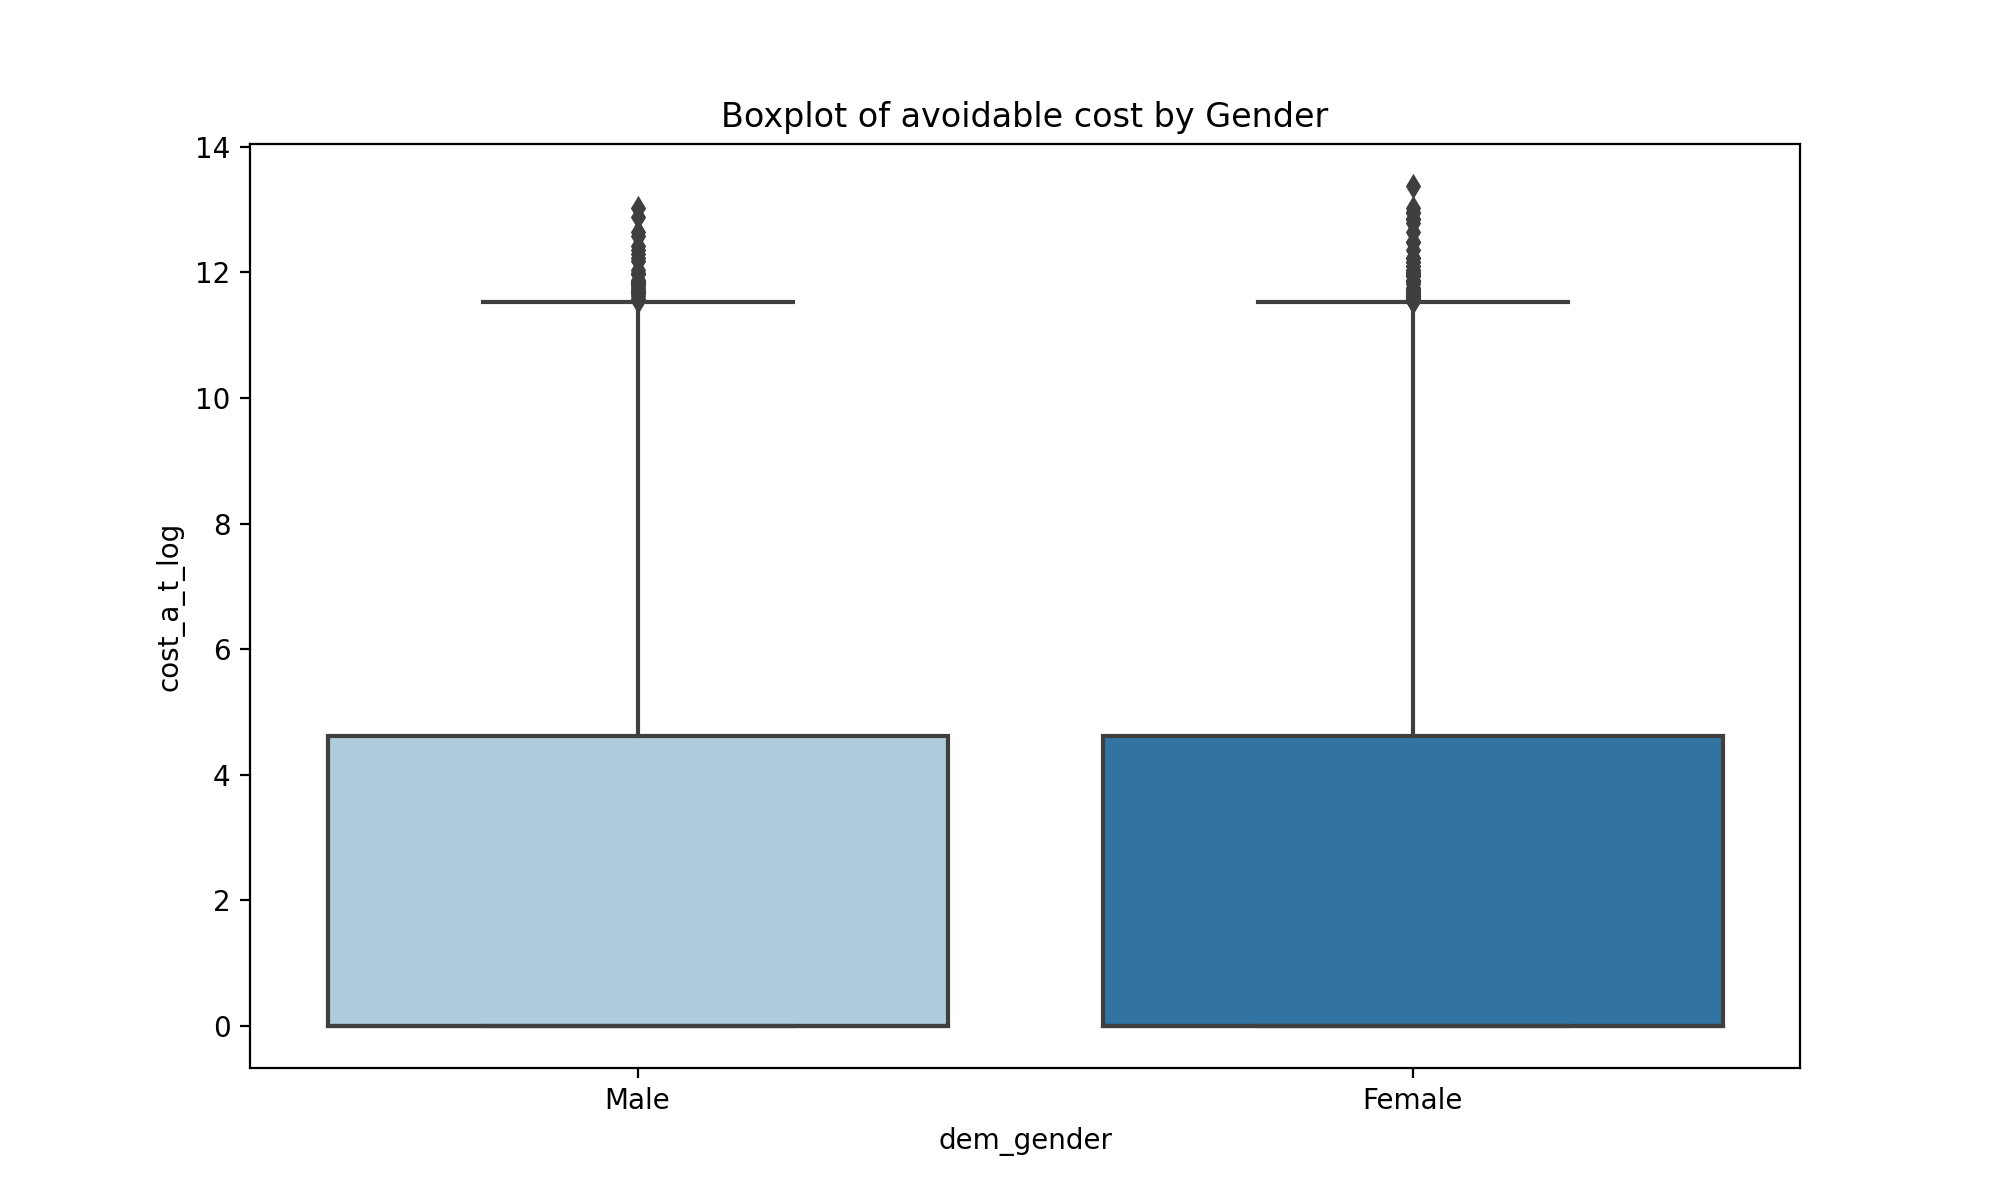

In [113]:
# Create side-by-side boxplots to demonstrate how variables may vary by demographic factors

plt.figure(figsize=(10, 6))
sns.boxplot(x='race', y='ghba1c_mean_t', data=data_df, palette='Set2')
plt.title('Boxplot of GHBA1C by Race')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='dem_gender', y='ghba1c_mean_t', data=data_df, palette='Paired')
plt.title('Boxplot of GHBA1C by Gender')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='race', y='gagne_sum_t', data=data_df, palette='Set2')
plt.title('Boxplot of Total number of active chronic illnesses by Race')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='dem_gender', y='gagne_sum_t', data=data_df, palette='Paired')
plt.title('Boxplot of Total number of active chronic illnesses by Gender')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='race', y='ldl_mean_t', data=data_df, palette='Set2')
plt.title('Boxplot of mean low-density lipoprotein by Race')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='dem_gender', y='ldl_mean_t', data=data_df, palette='Paired')
plt.title('Boxplot of mean low-density lipoprotein by Gender')
plt.show()

# Log-transform the variables
data_df['cost_t_log'] = np.log1p(data_df['cost_t'])
data_df['cost_a_t_log'] = np.log1p(data_df['cost_avoidable_t'])

plt.figure(figsize=(10, 6))
sns.boxplot(x='race', y='cost_t_log', data=data_df, palette='Set2')
plt.title('Boxplot of cost by Race')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='dem_gender', y='cost_t_log', data=data_df, palette='Paired')
plt.title('Boxplot of cost by Gender')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='race', y='cost_a_t_log', data=data_df, palette='Set2')
plt.title('Boxplot of avoidable cost by Race')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='dem_gender', y='cost_a_t_log', data=data_df, palette='Paired')
plt.title('Boxplot of avoidable cost by Gender')
plt.show()